# Imports

In [1]:
# Remove duplicate imports and sort them alphabetically
import itertools
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
import warnings

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

import xgboost as xgb

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Import Dataset

The Dataset with the following columns is imported

used variables:
- Total vehicles sold (Target)
    - Company car tax rate (%)
    - Google  Home charging (G)
    - Consumer confidence (E)
    - Gasoline (Euro95) - Average price (F)





In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\Final.CSV")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

Time Period (T)  Company car tax rate (%)  Home charging (G)  \
0      2007-01-01                        22                  0   
1      2007-02-01                        22                  0   
2      2007-03-01                        22                  0   
3      2007-04-01                        22                  0   
4      2007-05-01                        22                  0   

   Consumer confidence (E)  Gasoline (Euro95) - Average price (F)  \
0                     20.0                               1.303032   
1                     20.0                               1.325357   
2                     20.0                               1.379032   
3                     20.0                               1.426500   
4                     18.0                               1.466516   

   Total vehicles sold (Target)  
0                            31  
1                            39  
2                           123  
3                            62  
4                            84


> Following the steps for producing forcasts for time series data from Forecasting: Principles and Practice, the Pythonic Way, will be broken down into the following steps:

A structured process for producing forecasts:

0. Prepare the data (cleaning, formatting)
1. Visualize to identify patterns

    1a. split and transform the data split again
	Then just plot differencing, and say auto arima would probably use first differencing
2. Use automated algorithm 
Specify a model (using autoarima)
3. Check residuals  by plotting ACF of the residential and doing Portmanteau test > Ljung–Box Test: A refined version introduced in 1978 that adjusts for sample size and is more accurate
4. Do residuals look like white noise? If no plot ACF and check other candidate models.
Otherwise 
5. Generate forecasts
6. continue with specified  model and  add lagged features
	For lagged features check BIC+


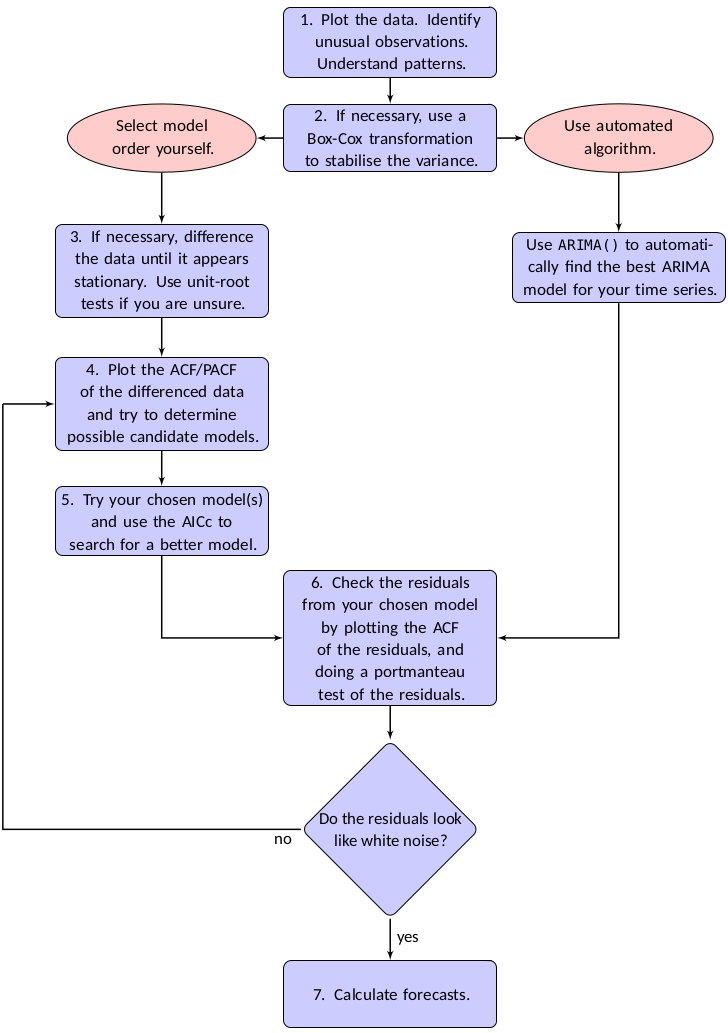



# 1. Prepare the data (cleaning, formatting) this was done in 
C:\Users\dylan\Trying hard\Tryhard\100%\Preprocessing.ipynb 

# 2. Split/ Visualize to identify patterns

to visualize and identify patterns in the data, we will use:
1. time series plots: here we can see 
these plots enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relationships between variables.
2. Scatterplot matrix:
    is used to explore relationships between time series.
3. Correlation matrix:
    is used to explore relationships between time series.

Train: 2007-01-01 00:00:00 to 2021-05-01 00:00:00 | 79.7% of data
Val:   2021-06-01 00:00:00 to 2023-03-01 00:00:00 | 10.1% of data
Test:  2023-04-01 00:00:00 to 2025-01-01 00:00:00 | 10.1% of data
Train size: 173, Val size: 22, Test size: 22


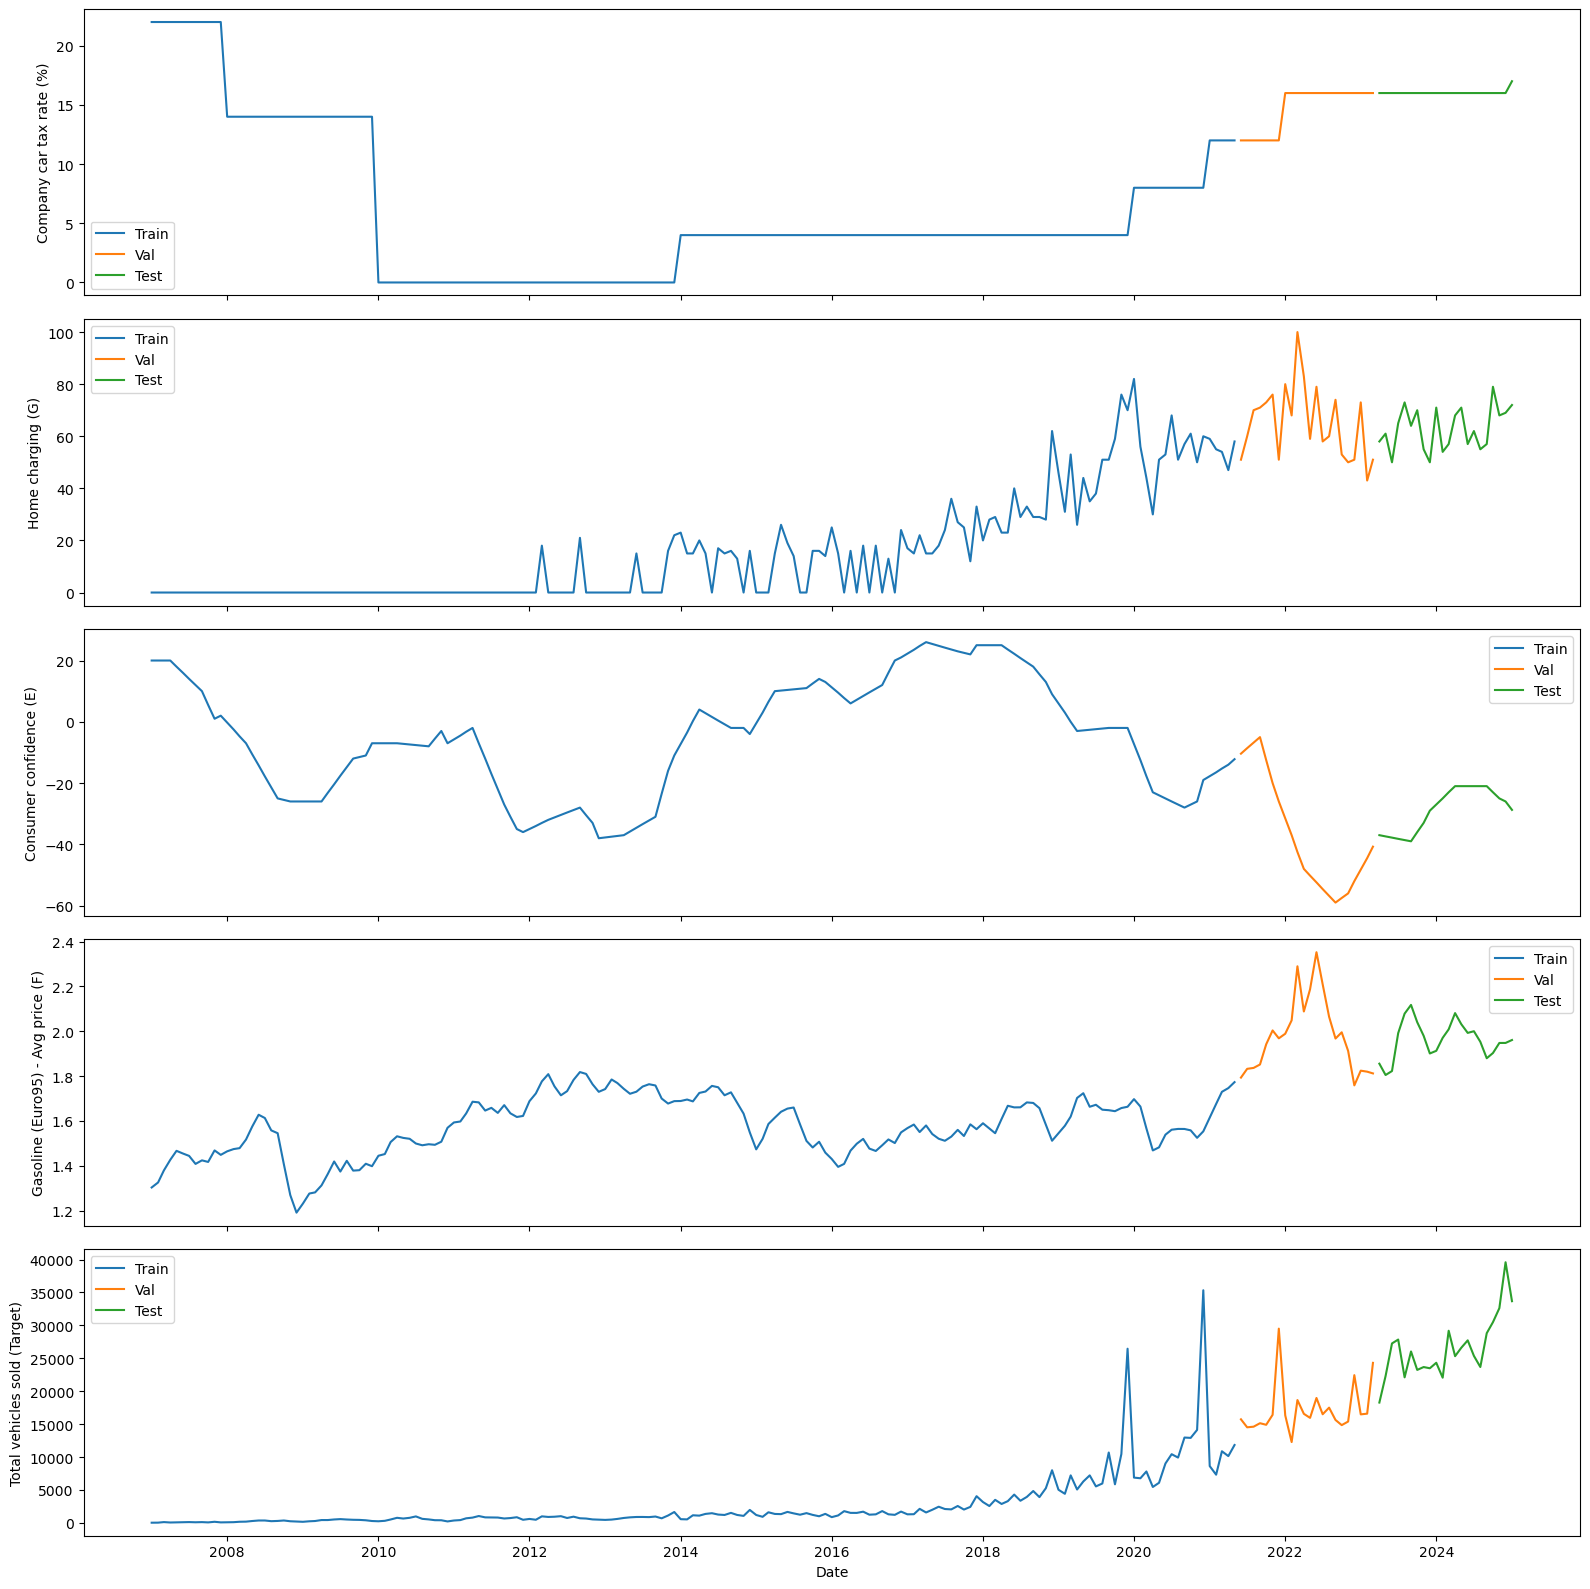

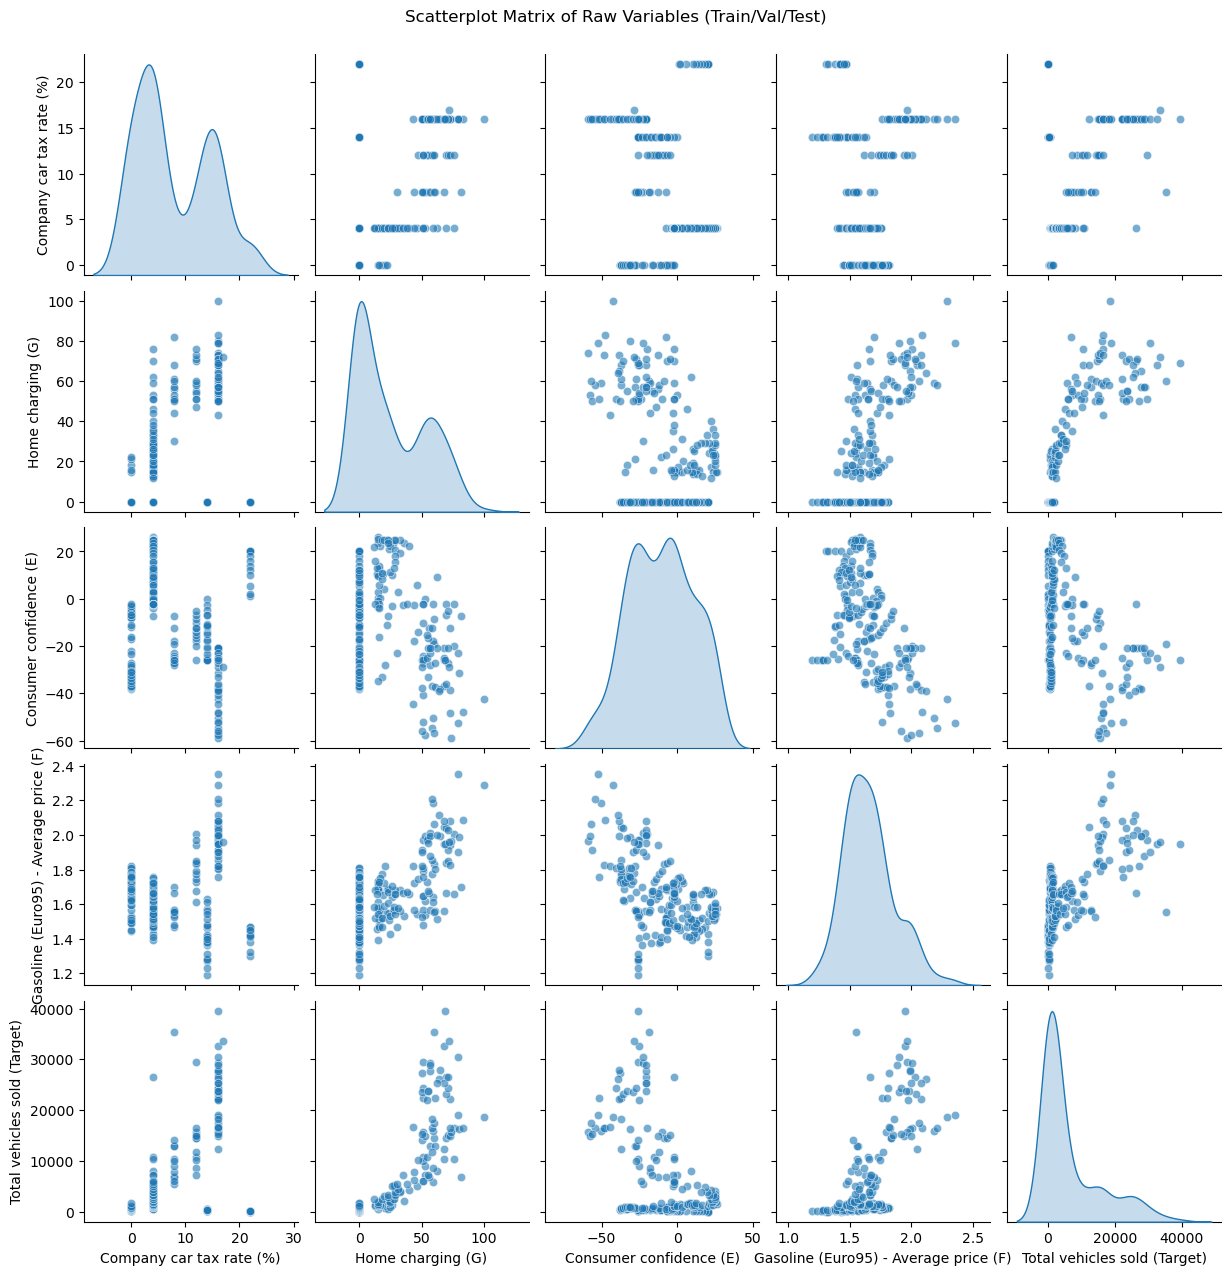

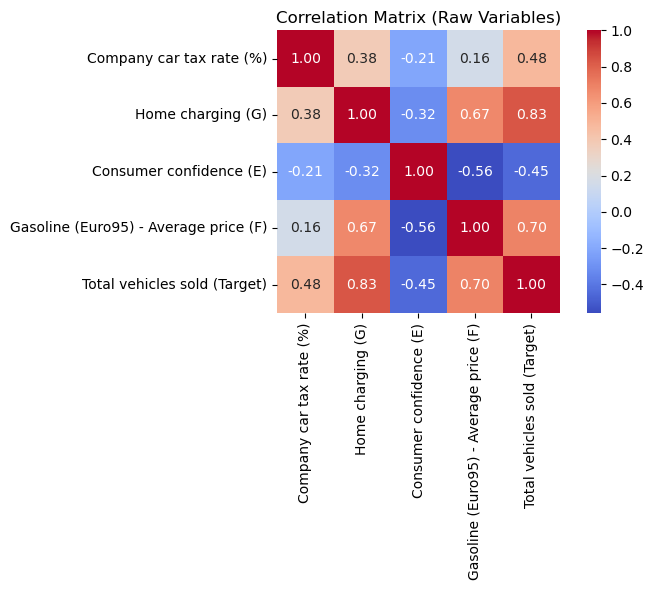

In [5]:
# Define features and target (raw data)
features_raw = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target_raw = 'Total vehicles sold (Target)'

# Calculate split indices
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Split the target (raw)
y_raw = df[target_raw]
y_train_raw = y_raw.iloc[:train_end]
y_val_raw = y_raw.iloc[train_end:val_end]
y_test_raw = y_raw.iloc[val_end:]

# Split each feature separately (raw)
companytax_train_raw = df['Company car tax rate (%)'].iloc[:train_end]
companytax_val_raw = df['Company car tax rate (%)'].iloc[train_end:val_end]
companytax_test_raw = df['Company car tax rate (%)'].iloc[val_end:]

homechg_train_raw = df['Home charging (G)'].iloc[:train_end]
homechg_val_raw = df['Home charging (G)'].iloc[train_end:val_end]
homechg_test_raw = df['Home charging (G)'].iloc[val_end:]

conf_train_raw = df['Consumer confidence (E)'].iloc[:train_end]
conf_val_raw = df['Consumer confidence (E)'].iloc[train_end:val_end]
conf_test_raw = df['Consumer confidence (E)'].iloc[val_end:]

gas_train_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[:train_end]
gas_val_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[train_end:val_end]
gas_test_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[val_end:]


# Print sizes
print(f"Train: {df['Time Period (T)'].iloc[y_train_raw.index[0]]} to {df['Time Period (T)'].iloc[y_train_raw.index[-1]]} | {len(y_train_raw)/n:.1%} of data")
print(f"Val:   {df['Time Period (T)'].iloc[y_val_raw.index[0]]} to {df['Time Period (T)'].iloc[y_val_raw.index[-1]]} | {len(y_val_raw)/n:.1%} of data")
print(f"Test:  {df['Time Period (T)'].iloc[y_test_raw.index[0]]} to {df['Time Period (T)'].iloc[y_test_raw.index[-1]]} | {len(y_test_raw)/n:.1%} of data")
print(f"Train size: {len(y_train_raw)}, Val size: {len(y_val_raw)}, Test size: {len(y_test_raw)}")

import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss


fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

# 1. Company car tax rate (%)
axs[0].plot(df['Time Period (T)'].iloc[:train_end], companytax_train_raw, label='Train')
axs[0].plot(df['Time Period (T)'].iloc[train_end:val_end], companytax_val_raw, label='Val')
axs[0].plot(df['Time Period (T)'].iloc[val_end:], companytax_test_raw, label='Test')
axs[0].set_ylabel('Company car tax rate (%)')
axs[0].legend()

# 2. Home charging (G)
axs[1].plot(df['Time Period (T)'].iloc[:train_end], homechg_train_raw, label='Train')
axs[1].plot(df['Time Period (T)'].iloc[train_end:val_end], homechg_val_raw, label='Val')
axs[1].plot(df['Time Period (T)'].iloc[val_end:], homechg_test_raw, label='Test')
axs[1].set_ylabel('Home charging (G)')
axs[1].legend()

# 3. Consumer confidence (E)
axs[2].plot(df['Time Period (T)'].iloc[:train_end], conf_train_raw, label='Train')
axs[2].plot(df['Time Period (T)'].iloc[train_end:val_end], conf_val_raw, label='Val')
axs[2].plot(df['Time Period (T)'].iloc[val_end:], conf_test_raw, label='Test')
axs[2].set_ylabel('Consumer confidence (E)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)
axs[3].plot(df['Time Period (T)'].iloc[:train_end], gas_train_raw, label='Train')
axs[3].plot(df['Time Period (T)'].iloc[train_end:val_end], gas_val_raw, label='Val')
axs[3].plot(df['Time Period (T)'].iloc[val_end:], gas_test_raw, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F)')
axs[3].legend()

# 5. Total vehicles sold (Target)
axs[4].plot(df['Time Period (T)'].iloc[:train_end], y_train_raw, label='Train')
axs[4].plot(df['Time Period (T)'].iloc[train_end:val_end], y_val_raw, label='Val')
axs[4].plot(df['Time Period (T)'].iloc[val_end:], y_test_raw, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# Scatter plot matrix (pairplot) for all features and target (raw splits)

sns.pairplot(df[features_raw + [target_raw]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables (Train/Val/Test)", y=1.02)
plt.show()

# Correlation matrix for all features and target (raw splits)
corr_matrix = df[features_raw + [target_raw]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Raw Variables)")
plt.tight_layout()
plt.show()






## Observations first plots 

> Talk about Trends: upward or downward drift over years.

Seasonality: recurring cycles (e.g., year-end sales spike).

Structural breaks: sudden shifts or regime changes.

Outliers: one-off jumps or drops.

key observations from the scattorplot matrix:

- Home charging and gasoline price show a moderately positive association with total vehicles sold, as indicated by the upward trend in their scatterplots.

- Company car tax rate appears to have a non-linear relationship with total vehicles sold; vehicle sales tend to increase when tax rates are lower.

- Consumer confidence shows a weaker, noisier relationship with vehicle sales, though a vague upward trend is present.

- Home charging shows strong positive correlation with gasoline prices, potentially reflecting a structural shift in energy preference.

# 3. Model Specification (NOG Afmaken)



My baseline approach will be: .... and  will integrate exogenous drivers:
using Arima, 

# 4.  Transformation & split

## 4a Apply train/val/test split

> Since there is alot of varience i will add boxcox transformation to the data, this will help to stabilize the variance and make the data more suitable for modeling.

## 4b Yeo–Johnson and boxcox  transformation 

Yeo–Johnson (like Box–Cox) primarily targets skewness—it finds a power transform that makes the distribution more symmetric and stabilizes variance globally. But time‐series variance often shifts because of:

Trends or level changes

Seasonal effects (e.g. summer peaks vs. winter troughs)

Structural breaks or exogenous shocks

BC Train: 173 rows | 79.7% of data
BC Val:   22 rows | 10.1% of data
BC Test:  22 rows | 10.1% of data
Company car tax rate (%)_bc               λ = 0.2205  shift = 0.0001
Home charging (G)_bc                      λ = -0.0268  shift = 0.0001
Consumer confidence (E)_yj                λ = 1.0165  shift = 0
Gasoline (Euro95) - Average price (F)_bc  λ = 2.7450  shift = 0
Total vehicles sold (Target)_bc           λ = -0.0017  shift = 0


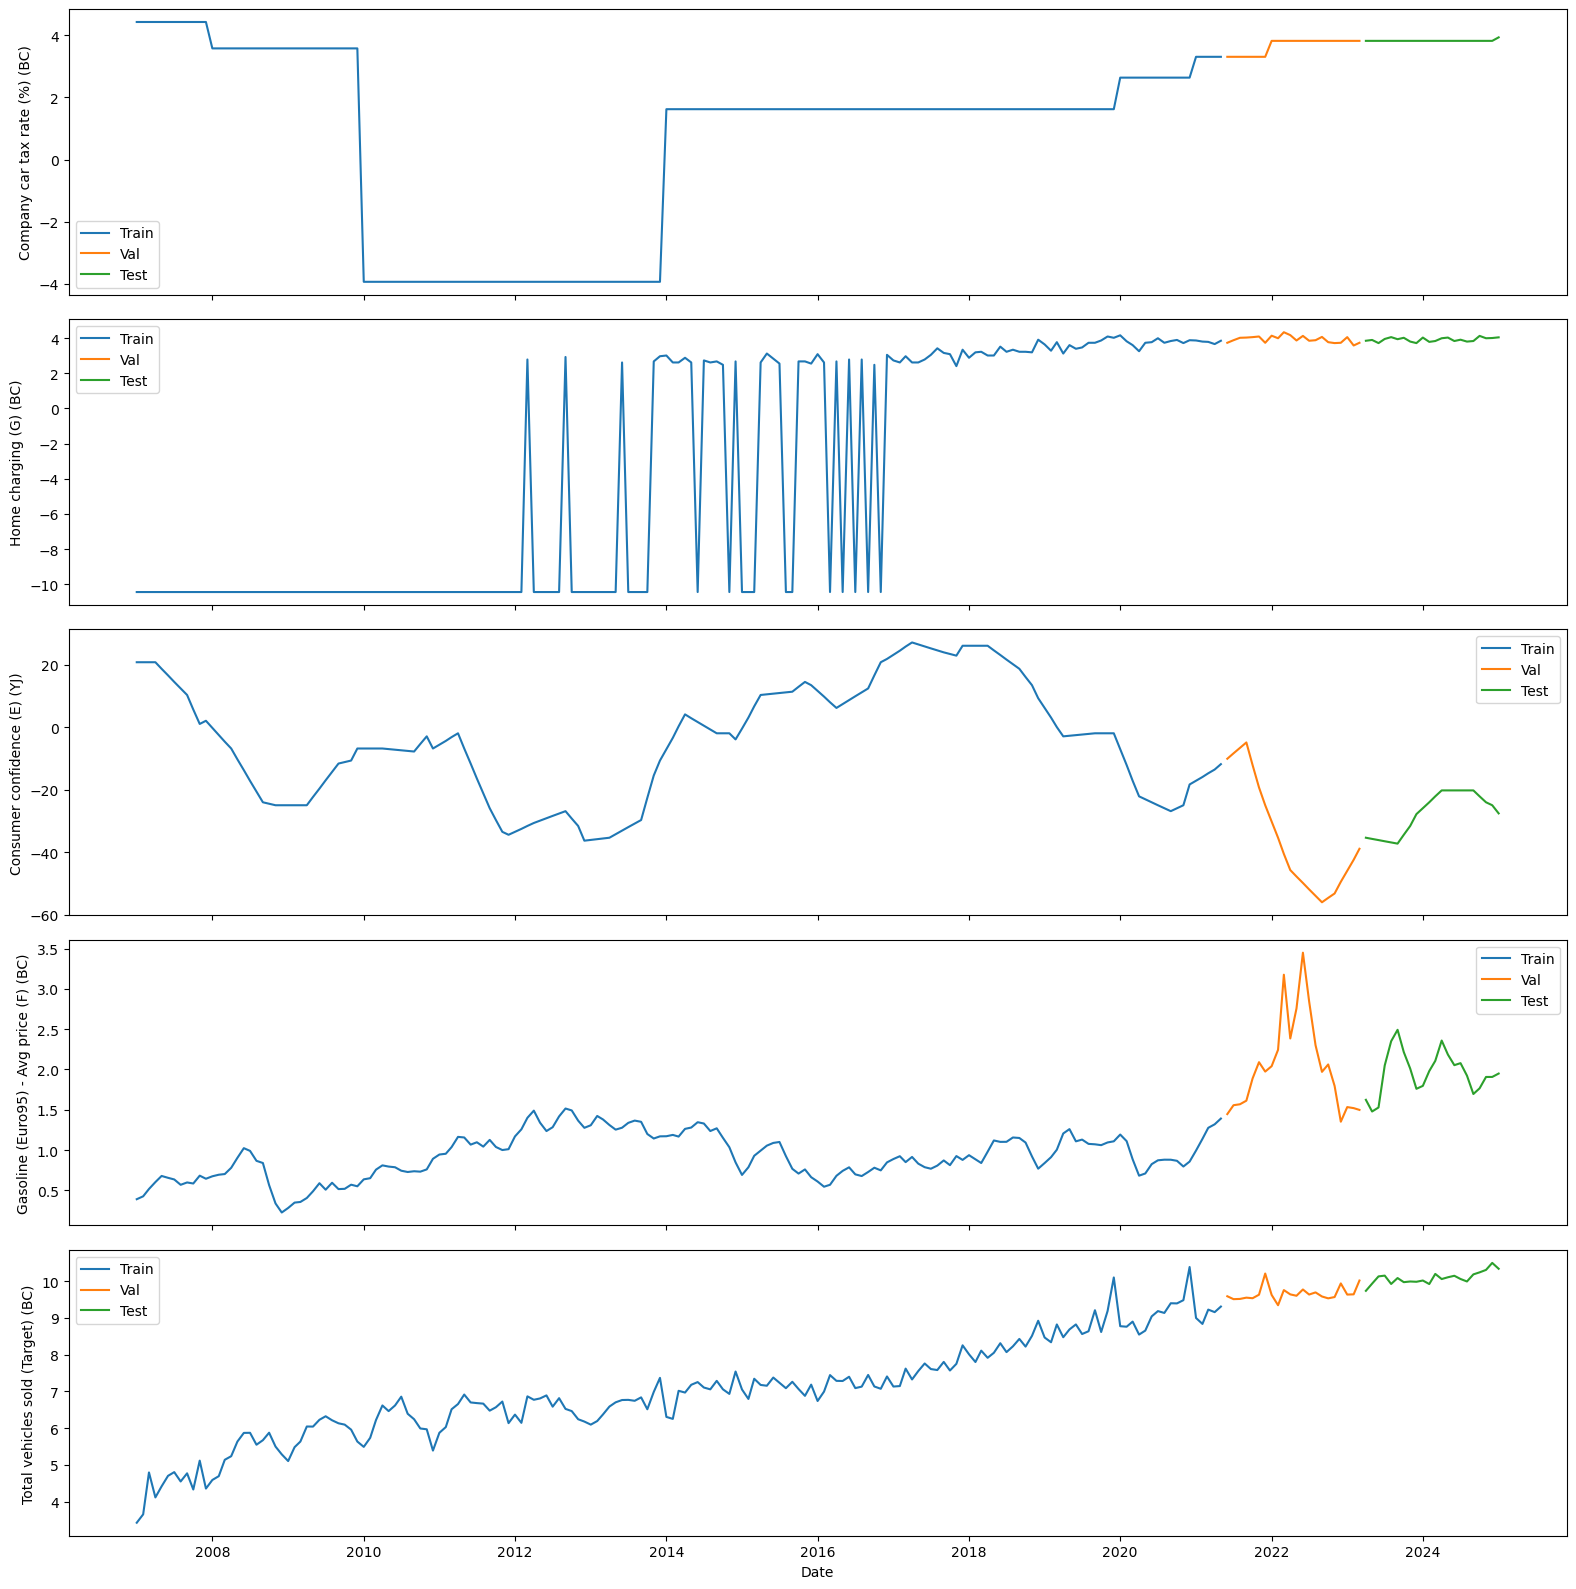

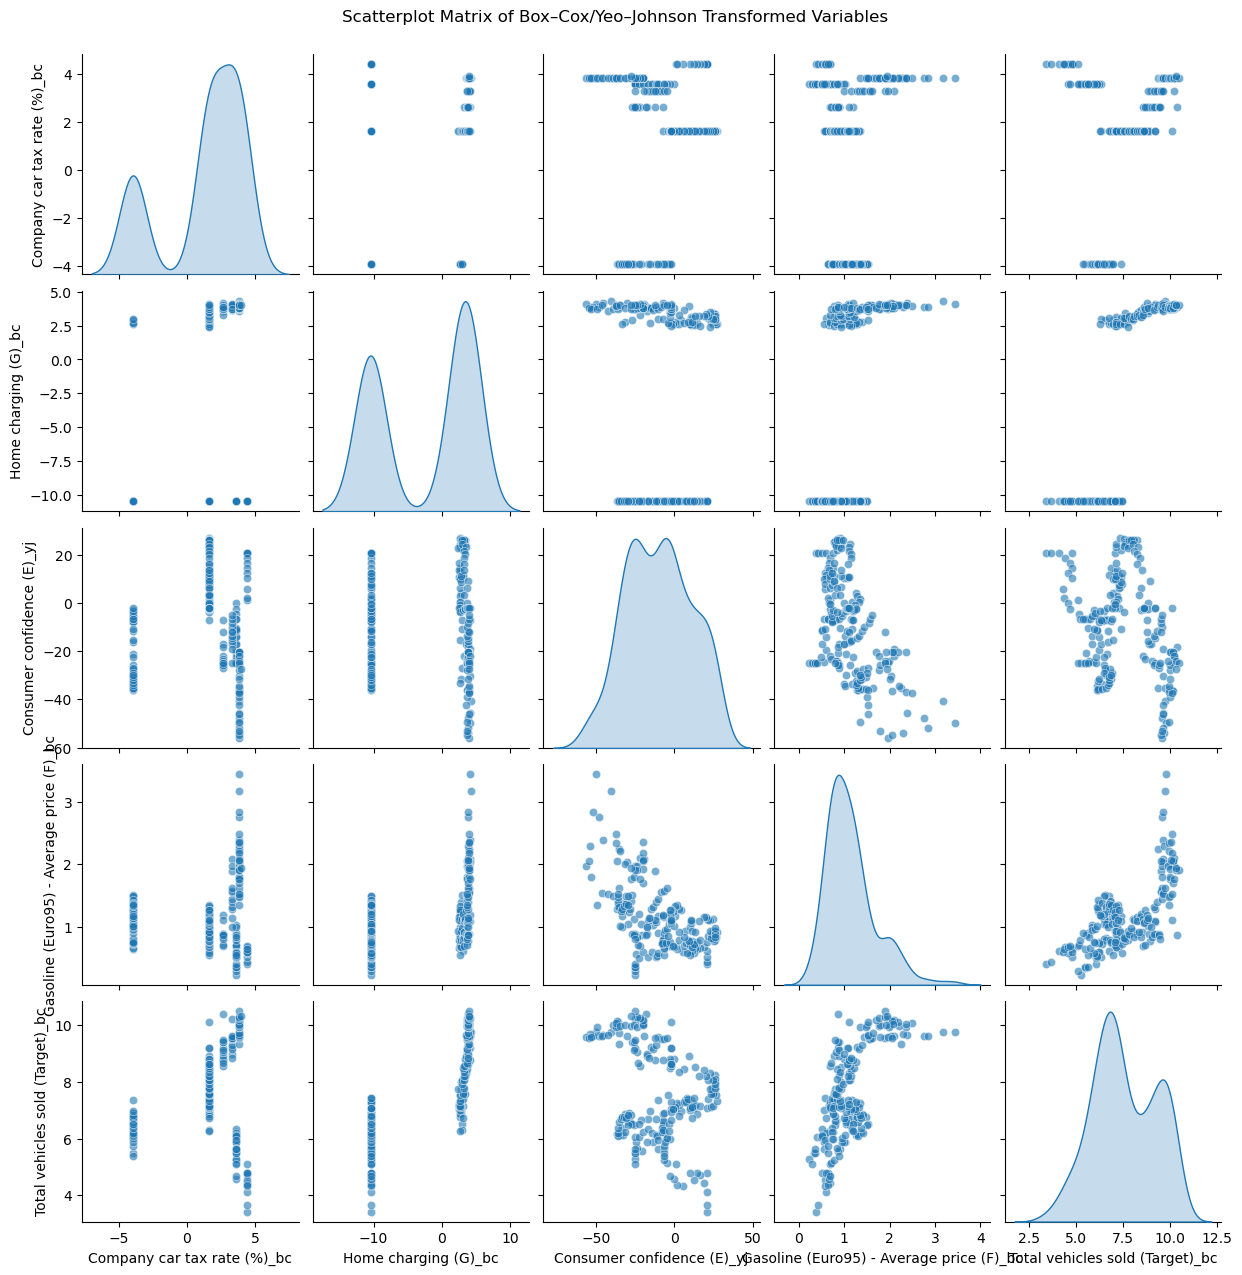

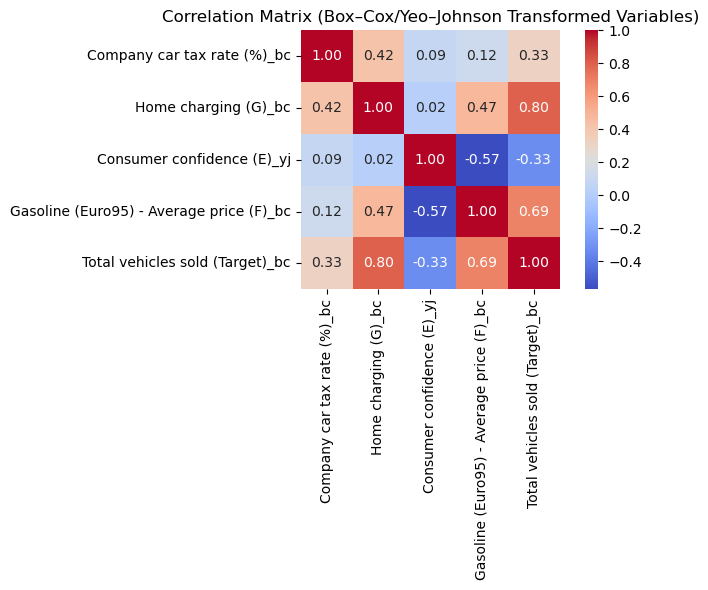

In [7]:
from sklearn.preprocessing import PowerTransformer
import numpy as np
import pandas as pd

features_bc = features_raw.copy()
target_bc = target_raw

boxcox_all = {}
boxcox_lambdas_all = {}
boxcox_shifts_all = {}

for col in features_bc + [target_bc]:
    # Skip Consumer Confidence (use Yeo–Johnson later)
    if "consumer confidence" in col.lower():
        continue

    train_series = df[col].iloc[:train_end].values.reshape(-1, 1)

    # Box–Cox requires strictly positive values: add shift if needed (on train only)
    min_train = train_series.min()
    shift = 0
    if min_train <= 0:
        shift = abs(min_train) + 1e-4  # Small buffer above zero
        train_series_shifted = train_series + shift
    else:
        train_series_shifted = train_series

    pt = PowerTransformer(method='box-cox', standardize=False)
    pt.fit(train_series_shifted)
    boxcox_lambdas_all[col] = pt.lambdas_[0]
    boxcox_shifts_all[col] = shift

    # Apply same shift to full data
    full_series = df[col].values.reshape(-1, 1)
    if shift != 0:
        full_series_shifted = full_series + shift
    else:
        full_series_shifted = full_series

    boxcox_all[col] = pt.transform(full_series_shifted).flatten()

# Now transform Consumer Confidence (Yeo–Johnson)
conf_col = [col for col in features_bc + [target_bc] if "consumer confidence" in col.lower()][0]
train_conf = df[conf_col].iloc[:train_end].values.reshape(-1, 1)
pt_conf = PowerTransformer(method='yeo-johnson', standardize=False)
pt_conf.fit(train_conf)
boxcox_lambdas_all[conf_col] = pt_conf.lambdas_[0]
boxcox_shifts_all[conf_col] = 0
full_conf = df[conf_col].values.reshape(-1, 1)
boxcox_all[conf_col] = pt_conf.transform(full_conf).flatten()

# 2. Build transformed DataFrame with _bc suffix (except conf, which gets _yj)
rename_map = {col: (f"{col}_yj" if "consumer confidence" in col.lower() else f"{col}_bc")
              for col in features_bc + [target_bc]}

bc_df = pd.DataFrame({
    rename_map[col]: boxcox_all[col]
    for col in features_bc + [target_bc]
})

features_bc = [rename_map[col] for col in features_bc]
target_bc   = rename_map[target_bc]

# 3. Define split indices for Box–Cox (same logic as raw)
n_bc         = len(bc_df)
train_end_bc = int(n_bc * 0.8)
val_end_bc   = int(n_bc * 0.9)
test_end_bc  = n_bc

# 4. Split Box–Cox–transformed data
y_train_bc = bc_df[target_bc].iloc[:train_end_bc]
y_val_bc   = bc_df[target_bc].iloc[train_end_bc:val_end_bc]
y_test_bc  = bc_df[target_bc].iloc[val_end_bc:]

companytax_train_bc = bc_df[[c for c in bc_df.columns if "Company car tax rate" in c][0]].iloc[:train_end_bc]
companytax_val_bc   = bc_df[[c for c in bc_df.columns if "Company car tax rate" in c][0]].iloc[train_end_bc:val_end_bc]
companytax_test_bc  = bc_df[[c for c in bc_df.columns if "Company car tax rate" in c][0]].iloc[val_end_bc:]

homechg_train_bc = bc_df[[c for c in bc_df.columns if "Home charging" in c][0]].iloc[:train_end_bc]
homechg_val_bc   = bc_df[[c for c in bc_df.columns if "Home charging" in c][0]].iloc[train_end_bc:val_end_bc]
homechg_test_bc  = bc_df[[c for c in bc_df.columns if "Home charging" in c][0]].iloc[val_end_bc:]

conf_train_yj = bc_df[[c for c in bc_df.columns if "consumer confidence" in c.lower()][0]].iloc[:train_end_bc]
conf_val_yj   = bc_df[[c for c in bc_df.columns if "consumer confidence" in c.lower()][0]].iloc[train_end_bc:val_end_bc]
conf_test_yj  = bc_df[[c for c in bc_df.columns if "consumer confidence" in c.lower()][0]].iloc[val_end_bc:]

gas_train_bc = bc_df[[c for c in bc_df.columns if "Gasoline" in c][0]].iloc[:train_end_bc]
gas_val_bc   = bc_df[[c for c in bc_df.columns if "Gasoline" in c][0]].iloc[train_end_bc:val_end_bc]
gas_test_bc  = bc_df[[c for c in bc_df.columns if "Gasoline" in c][0]].iloc[val_end_bc:]

# Print split info for Box–Cox
print(f"BC Train: {train_end_bc} rows | {train_end_bc/n_bc:.1%} of data")
print(f"BC Val:   {val_end_bc-train_end_bc} rows | {(val_end_bc-train_end_bc)/n_bc:.1%} of data")
print(f"BC Test:  {test_end_bc-val_end_bc} rows | {(test_end_bc-val_end_bc)/n_bc:.1%} of data")

for orig_col in features_bc + [target_bc]:
    base_col = orig_col.replace("_bc", "").replace("_yj", "")
    lam = boxcox_lambdas_all[base_col]
    shift = boxcox_shifts_all[base_col]
    print(f"{orig_col:40s}  λ = {lam:.4f}  shift = {shift:.4g}")



import matplotlib.pyplot as plt
import seaborn as sns

# --- Box–Cox (and Yeo–Johnson for Consumer Confidence) Train/Val/Test Splits: Time Series Plots ---

fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

time_index = df['Time Period (T)']

# 1. Company car tax rate (%)_bc
axs[0].plot(time_index.iloc[:train_end_bc], companytax_train_bc, label='Train')
axs[0].plot(time_index.iloc[train_end_bc:val_end_bc], companytax_val_bc, label='Val')
axs[0].plot(time_index.iloc[val_end_bc:], companytax_test_bc, label='Test')
axs[0].set_ylabel('Company car tax rate (%) (BC)')
axs[0].legend()

# 2. Home charging (G)_bc
axs[1].plot(time_index.iloc[:train_end_bc], homechg_train_bc, label='Train')
axs[1].plot(time_index.iloc[train_end_bc:val_end_bc], homechg_val_bc, label='Val')
axs[1].plot(time_index.iloc[val_end_bc:], homechg_test_bc, label='Test')
axs[1].set_ylabel('Home charging (G) (BC)')
axs[1].legend()

# 3. Consumer confidence (E)_yj
axs[2].plot(time_index.iloc[:train_end_bc], conf_train_yj, label='Train')
axs[2].plot(time_index.iloc[train_end_bc:val_end_bc], conf_val_yj, label='Val')
axs[2].plot(time_index.iloc[val_end_bc:], conf_test_yj, label='Test')
axs[2].set_ylabel('Consumer confidence (E) (YJ)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)_bc
axs[3].plot(time_index.iloc[:train_end_bc], gas_train_bc, label='Train')
axs[3].plot(time_index.iloc[train_end_bc:val_end_bc], gas_val_bc, label='Val')
axs[3].plot(time_index.iloc[val_end_bc:], gas_test_bc, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F) (BC)')
axs[3].legend()

# 5. Total vehicles sold (Target)_bc
axs[4].plot(time_index.iloc[:train_end_bc], y_train_bc, label='Train')
axs[4].plot(time_index.iloc[train_end_bc:val_end_bc], y_val_bc, label='Val')
axs[4].plot(time_index.iloc[val_end_bc:], y_test_bc, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target) (BC)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# --- Scatter plot matrix (pairplot) for Box–Cox/Yeo–Johnson transformed features + target ---
sns.pairplot(bc_df, diag_kind="kde", plot_kws={'alpha': 0.6})
plt.suptitle("Scatterplot Matrix of Box–Cox/Yeo–Johnson Transformed Variables", y=1.02)
plt.show()

# --- Correlation matrix ---
corr_matrix_bc = bc_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_bc, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Box–Cox/Yeo–Johnson Transformed Variables)")
plt.tight_layout()
plt.show()


# 5 Establish Simple benchmark
for benchmark i wil fit the following naive models on vehicles sold 
- Naïve: last observed value.
- Seasonal naïve: last value from the same season.
- Drift: line from first to last point.


> Beargumenteer waar om benchamrk op raw data is geplot en niet op de transfomeerde data 

✅ Yes, benchmarks can be set on YJ-transformed data.
But for performance metrics like RMSE and MAPE, you should:

⚠️ Always inverse-transform the forecasts back to the original (raw) scale before calculating those metrics.

> Eventueel MESA uithalen 

Naïve 3-step RMSE (original): 5360.99
Naïve 3-step MAPE (original): 19.05%
Naïve 3-step MASE (original): 3.463
Seasonal Naïve 3-step RMSE (original): 4456.62
Seasonal Naïve 3-step MAPE (original): 21.24%
Seasonal Naïve 3-step MASE (original): 3.583
Drift 3-step RMSE (original): 4917.99
Drift 3-step MAPE (original): 20.00%
Drift 3-step MASE (original): 3.350


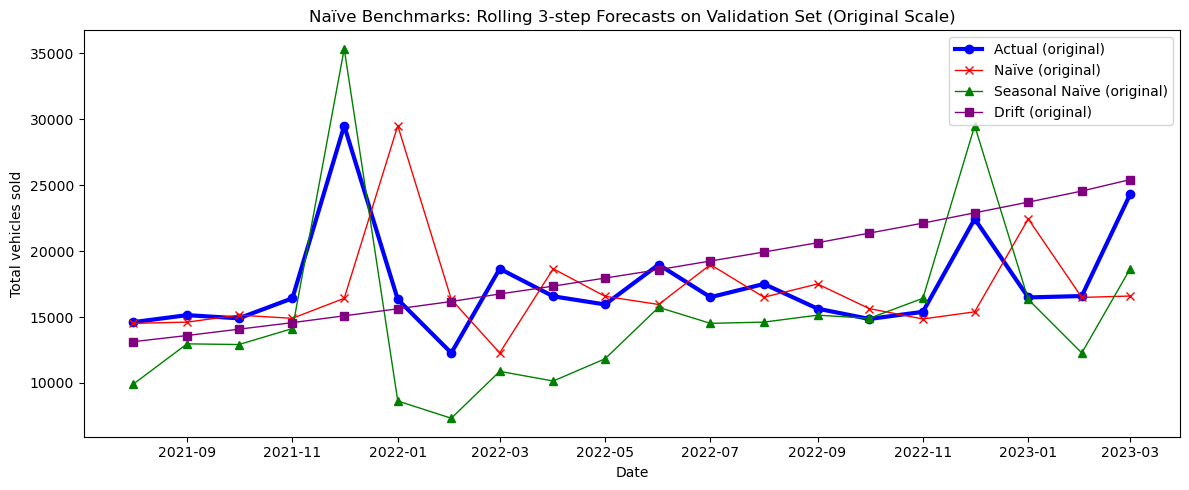

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.special import inv_boxcox

horizon = 3  # Forecast horizon

# Use Box–Cox transformed splits
y_all_bc = np.concatenate([y_train_bc.values, y_val_bc.values])  # Full BC series for rolling forecast (train + val)
y_val_full_bc = y_val_bc.values
y_train_full_bc = y_train_bc.values

# Find the lambda and shift used for Box–Cox target
target_col_raw = target_raw
lam_bc = boxcox_lambdas_all[target_col_raw]
shift_bc = boxcox_shifts_all[target_col_raw]

# === 1. Naïve Forecast (BC) ===
naive_preds_bc = []
for t in range(len(y_val_full_bc) - horizon + 1):
    last_obs = y_all_bc[train_end_bc + t + horizon - 2]
    naive_preds_bc.append(last_obs)
naive_preds_bc = np.array(naive_preds_bc)
naive_actuals_bc = y_val_full_bc[horizon-1:]

naive_rmse_bc = np.sqrt(mean_squared_error(naive_actuals_bc, naive_preds_bc))
naive_mape_bc = mean_absolute_percentage_error(naive_actuals_bc, naive_preds_bc)

# === 2. Seasonal Naïve Forecast (BC, 12 months ago) ===
season_length = 12
seasonal_naive_preds_bc = []
for t in range(len(y_val_full_bc) - horizon + 1):
    idx = train_end_bc + t + horizon - 1
    if idx - season_length >= 0:
        pred = y_all_bc[idx - season_length]
    else:
        pred = y_all_bc[train_end_bc + t + horizon - 2]
    seasonal_naive_preds_bc.append(pred)
seasonal_naive_preds_bc = np.array(seasonal_naive_preds_bc)

seasonal_naive_rmse_bc = np.sqrt(mean_squared_error(naive_actuals_bc, seasonal_naive_preds_bc))
seasonal_naive_mape_bc = mean_absolute_percentage_error(naive_actuals_bc, seasonal_naive_preds_bc)

# === 3. Drift Forecast (BC) ===
drift_preds_bc = []
n_train_bc = len(y_train_full_bc)
for t in range(len(y_val_full_bc) - horizon + 1):
    steps = n_train_bc + t + horizon - 1
    drift = y_train_full_bc[-1] + ((steps - (n_train_bc - 1)) * (y_train_full_bc[-1] - y_train_full_bc[0]) / (n_train_bc - 1))
    drift_preds_bc.append(drift)
drift_preds_bc = np.array(drift_preds_bc)
drift_rmse_bc = np.sqrt(mean_squared_error(naive_actuals_bc, drift_preds_bc))
drift_mape_bc = mean_absolute_percentage_error(naive_actuals_bc, drift_preds_bc)

# --- Inverse transform forecasts for reporting on original scale (Box–Cox) ---
def inv_boxcox_with_shift(z, lam, shift):
    return inv_boxcox(z, lam) - shift

actuals_orig = inv_boxcox_with_shift(naive_actuals_bc, lam_bc, shift_bc)
naive_preds_orig = inv_boxcox_with_shift(naive_preds_bc, lam_bc, shift_bc)
seasonal_naive_preds_orig = inv_boxcox_with_shift(seasonal_naive_preds_bc, lam_bc, shift_bc)
drift_preds_orig = inv_boxcox_with_shift(drift_preds_bc, lam_bc, shift_bc)

# --- MASE metric ---
def mase(y_true, y_pred, y_train, m=1):
    # Mean absolute error of forecast
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    # Mean absolute error of naive seasonal forecast on training set
    mae_naive = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    return mae_forecast / mae_naive if mae_naive != 0 else np.nan

# Compute metrics on original scale
naive_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, naive_preds_orig))
naive_mape_orig = mean_absolute_percentage_error(actuals_orig, naive_preds_orig)
naive_mase_orig = mase(actuals_orig, naive_preds_orig, inv_boxcox_with_shift(y_train_bc.values, lam_bc, shift_bc), m=horizon)

seasonal_naive_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, seasonal_naive_preds_orig))
seasonal_naive_mape_orig = mean_absolute_percentage_error(actuals_orig, seasonal_naive_preds_orig)
seasonal_naive_mase_orig = mase(actuals_orig, seasonal_naive_preds_orig, inv_boxcox_with_shift(y_train_bc.values, lam_bc, shift_bc), m=horizon)

drift_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, drift_preds_orig))
drift_mape_orig = mean_absolute_percentage_error(actuals_orig, drift_preds_orig)
drift_mase_orig = mase(actuals_orig, drift_preds_orig, inv_boxcox_with_shift(y_train_bc.values, lam_bc, shift_bc), m=horizon)

print(f"Naïve 3-step RMSE (original): {naive_rmse_orig:.2f}")
print(f"Naïve 3-step MAPE (original): {naive_mape_orig:.2%}")
print(f"Naïve 3-step MASE (original): {naive_mase_orig:.3f}")
print(f"Seasonal Naïve 3-step RMSE (original): {seasonal_naive_rmse_orig:.2f}")
print(f"Seasonal Naïve 3-step MAPE (original): {seasonal_naive_mape_orig:.2%}")
print(f"Seasonal Naïve 3-step MASE (original): {seasonal_naive_mase_orig:.3f}")
print(f"Drift 3-step RMSE (original): {drift_rmse_orig:.2f}")
print(f"Drift 3-step MAPE (original): {drift_mape_orig:.2%}")
print(f"Drift 3-step MASE (original): {drift_mase_orig:.3f}")

# Plot actuals and forecasts on the original (inverse-transformed) scale
x_dates_bc = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc]
plt.figure(figsize=(12, 5))
plt.plot(x_dates_bc, actuals_orig, label='Actual (original)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_bc, naive_preds_orig, label='Naïve (original)', marker='x', color='red', linewidth=1)
plt.plot(x_dates_bc, seasonal_naive_preds_orig, label='Seasonal Naïve (original)', marker='^', color='green', linewidth=1)
plt.plot(x_dates_bc, drift_preds_orig, label='Drift (original)', marker='s', color='purple', linewidth=1)
plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Validation Set (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

All forecasting is performed in the transformed space.

All error metrics are reported on the inverse-transformed (original) scale for interpretability.

# 6. Baseline ARIMA (Univariate)

## 6a Auto ARIMA using The Hyndman & Khandakar algorithm

autoarima from  https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html

In [51]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import pandas as pd

# Instantiate AutoARIMA with AICc optimization
model = AutoARIMA(
    season_length=12,
    ic='aicc',     # optimize using AICc
    stepwise=True,
    trace=True
)

# Prepare the training DataFrame using only the training data
df_fit = pd.DataFrame({
    "unique_id": "series_1",
    "ds": df["Time Period (T)"].iloc[:train_end_bc],
    "y": y_train_bc.values
})

# Initialize and fit the StatsForecast forecast engine
sf = StatsForecast(models=[model], freq="M", n_jobs=-1)
sf = sf.fit(df=df_fit)

# Forecast horizon = length of validation set
h = len(y_val_bc)

# Generate forecasts for validation period
forecast_df = sf.predict(h=h)

print(forecast_df.head())



ARIMA(2,1,2)(1,1,1)[12]                   :26.736760797477906

ARIMA(0,1,0)(0,1,0)[12]                   :71.19510034922324

ARIMA(1,1,0)(1,1,0)[12]                   :31.59144149340849

ARIMA(0,1,1)(0,1,1)[12]                   :15.275480343979517

ARIMA(0,1,1)(0,1,0)[12]                   :27.831000315681166

ARIMA(0,1,1)(1,1,1)[12]                   :17.748809978038203

ARIMA(0,1,1)(0,1,2)[12]                   :16.533763859745143

ARIMA(0,1,1)(1,1,0)[12]                   :18.358254172829696

ARIMA(0,1,1)(1,1,2)[12]                   :18.565311141342725

ARIMA(0,1,0)(0,1,1)[12]                   :58.53964944471008

ARIMA(1,1,1)(0,1,1)[12]                   :16.89530919605739

ARIMA(0,1,2)(0,1,1)[12]                   :17.105312889486818

ARIMA(1,1,0)(0,1,1)[12]                   :27.796724506574

ARIMA(1,1,2)(0,1,1)[12]                   :18.564701516461376
Now re-fitting the best model(s) without approximations...


ARIMA(0,1,1)(0,1,1)[12]                   :15.275480343979517
  

Best model from Autoarima was: ARIMA(0,1,1)(0,1,1)[12]

> Next step is to test residuels

AIC (last SARIMAX fit): -12.37
BIC (last SARIMAX fit): -3.05


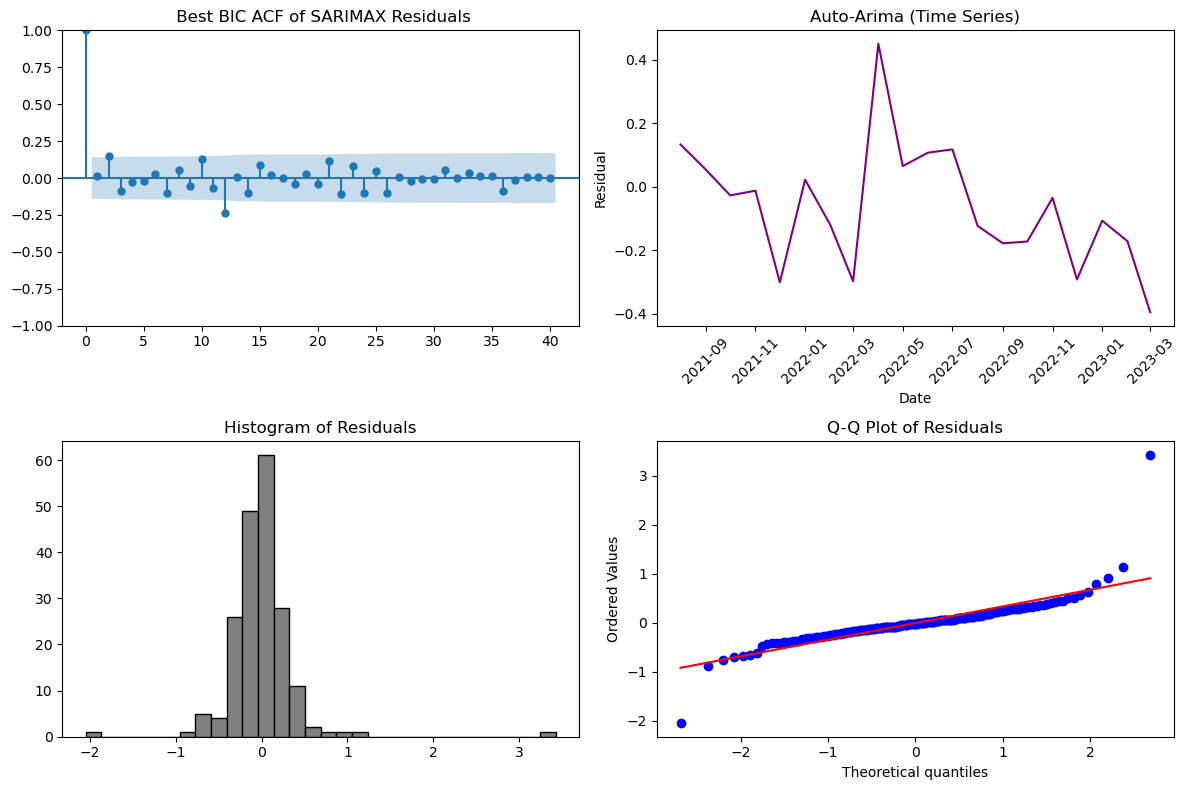

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  12.350187   0.262303
20  29.641343   0.075877
30  41.834700   0.073938


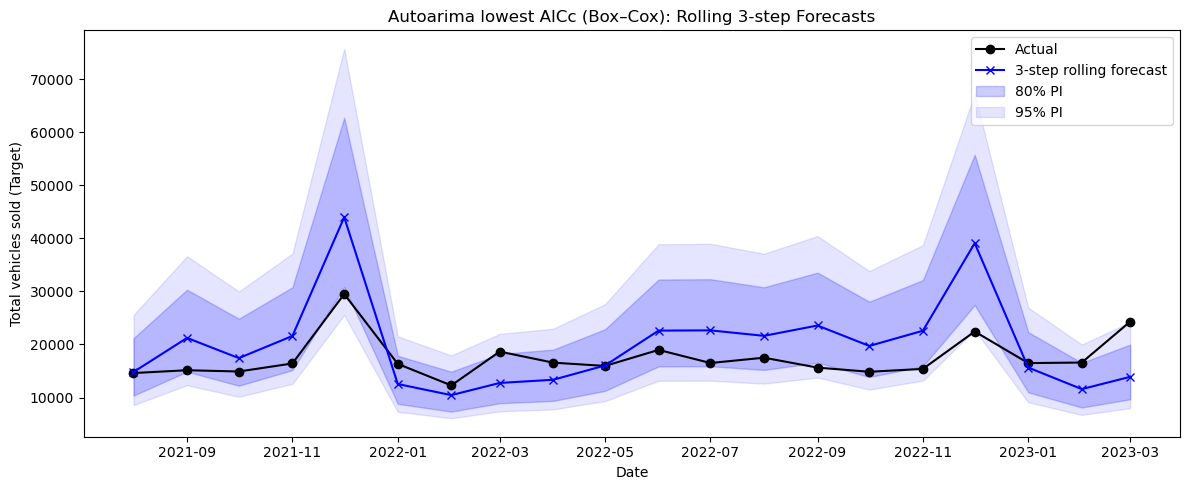

Validation RMSE (rolling): 6934.93
Validation MAPE (rolling): 29.58%


In [61]:
from scipy.special import inv_boxcox

# 1. Set forecast horizon
horizon = 3  # Number of steps ahead to forecast

# 2. Grab Box–Cox‐transformed train/val arrays (no manual differencing)
train_bc = y_train_bc.values  # Box–Cox transformed training data
val_bc   = y_val_bc.values    # Box–Cox transformed validation data

# 3. Raw (original‐scale) validation actuals, aligned for rolling forecast
val_actuals = df[target_raw].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc]

# 5. Rolling SARIMAX forecasts (let model handle differencing)
preds_level   = []
ci80_lower    = []
ci80_upper    = []
ci95_lower    = []
ci95_upper    = []

# Get Box–Cox lambda and shift for the target
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def inv_boxcox_with_shift(z, lam, shift):
    return inv_boxcox(z, lam) - shift

for t in range(len(val_bc) - horizon + 1):
    history = np.concatenate([train_bc, val_bc[:t]])  # Expanding window

    model = SARIMAX(
        history,
        order=(0, 1, 1),  # Let SARIMAX do the differencing (d=1)
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon)
    bc_forecast_level = fc.predicted_mean[-1]

    # Invert Box–Cox for forecast
    preds_level.append(inv_boxcox_with_shift(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox_with_shift(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox_with_shift(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox_with_shift(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox_with_shift(np.array([ci95_u]), lam, shift)[0])

# 6. Align actuals for metric calculation (inverse Box–Cox)
actuals_level = inv_boxcox_with_shift(val_bc[horizon-1:], lam, shift)

# 9. Last fitted model’s AIC/BIC and residual diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title(" Best BIC ACF of SARIMAX Residuals")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Auto-Arima (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45) 

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Autoarima lowest AICc (Box–Cox): Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Metrics (on original scale)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


Since the risudeals dont look like white noice, i Will continue manually tuning 

## 6b Manual ARIMA Tuning

> since the autoarima showsn far from supurb results, i wil continue with the manual tuning.
first stepp will be to plot the ACF and PACF of THE DIFFERENCED data to identify potential AR and MA terms.

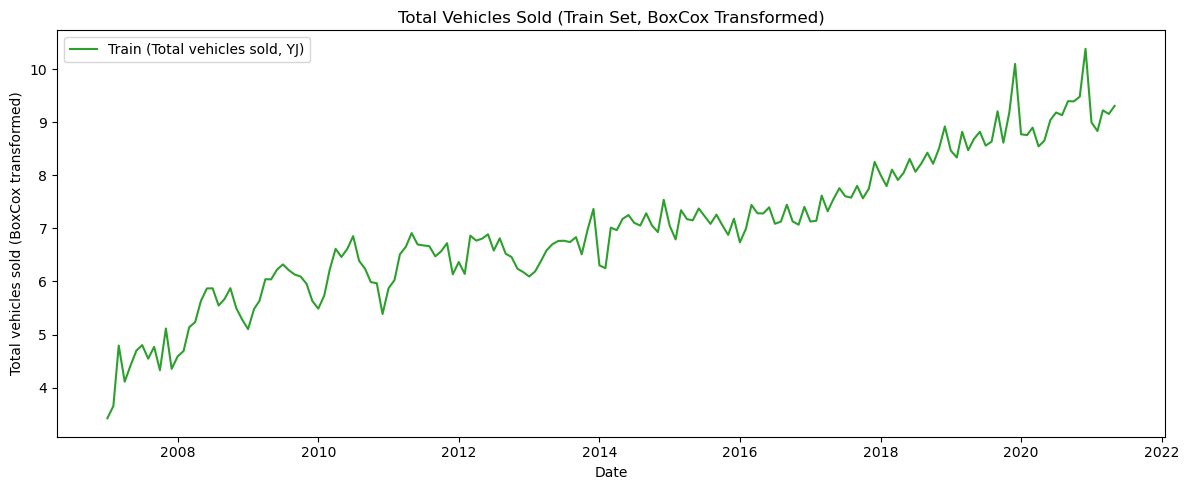

In [56]:
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"].iloc[y_train_bc.index], y_train_bc, color='tab:green', label='Train (Total vehicles sold, YJ)')
plt.xlabel("Date")
plt.ylabel("Total vehicles sold (BoxCox transformed)")
plt.title("Total Vehicles Sold (Train Set, BoxCox Transformed)")
plt.legend()
plt.tight_layout()
plt.show()



==== Stationarity tests for y_train_bc ====
ADF stat: -0.2705 | p-value: 0.9296 | Non-stationary (ADF)
KPSS stat: 1.8855 | p-value: 0.0100 | Non-stationary (KPSS)


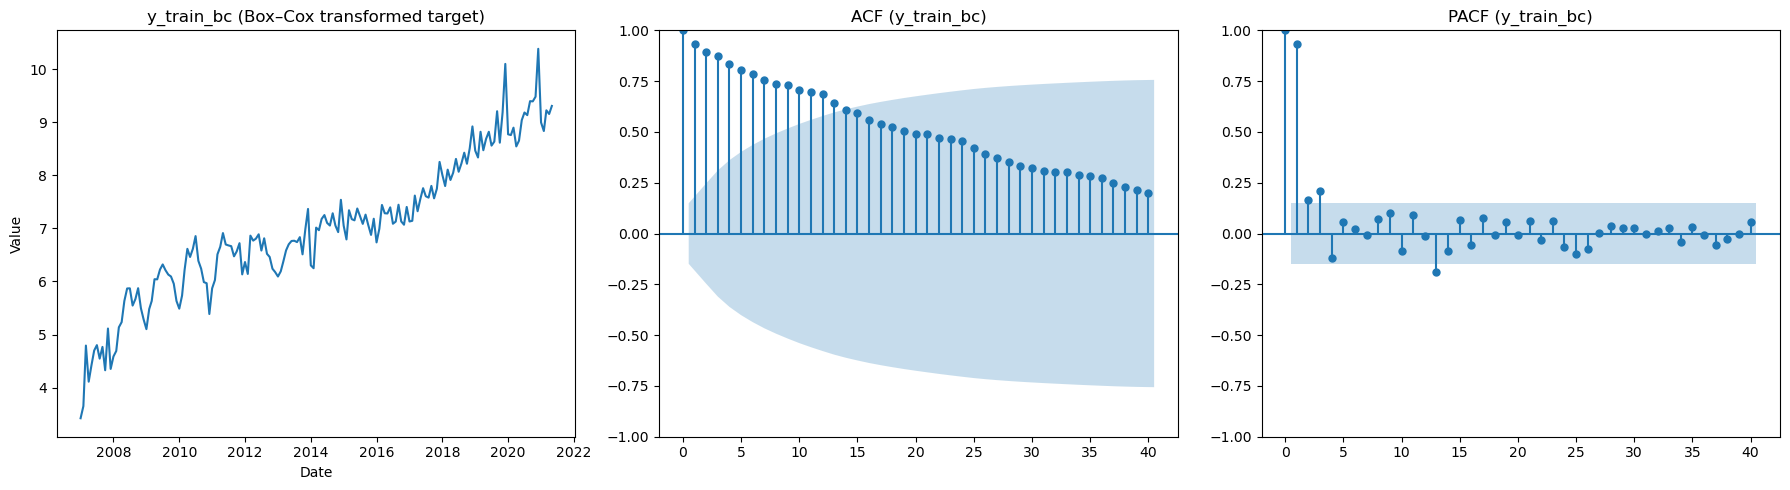

In [60]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Use Box–Cox transformed target (y_train_bc)
series = y_train_bc.astype(float).values

# Run ADF and KPSS tests (no differencing)
adf_result = adfuller(series)
kpss_result = kpss(series, regression='c', nlags="auto")

print(f"\n==== Stationarity tests for y_train_bc ====")
print(f"ADF stat: {adf_result[0]:.4f} | p-value: {adf_result[1]:.4f} | {'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'} (ADF)")
print(f"KPSS stat: {kpss_result[0]:.4f} | p-value: {kpss_result[1]:.4f} | {'Stationary' if kpss_result[1] >= 0.05 else 'Non-stationary'} (KPSS)")

# Plot time series, ACF, and PACF
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Time series plot
axes[0].plot(df["Time Period (T)"].iloc[:len(y_train_bc)], series, color='tab:blue')
axes[0].set_title("y_train_bc (Box–Cox transformed target)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Value")

# 2. ACF plot
plot_acf(series, ax=axes[1], lags=40)
axes[1].set_title("ACF (y_train_bc)")

# 3. PACF plot
plot_pacf(series, ax=axes[2], lags=40, method='ywm')
axes[2].set_title("PACF (y_train_bc)")

plt.tight_layout()
plt.show()

> **ACF Plot Observations**

- Lag 1: Large positive autocorrelation, far beyond the confidence bands.

- Gradual decay in autocorrelations over lags 2–11, consistent with a persistent trend.

- Lag 12: Distinct positive spike (seasonal period), exceeding the confidence limit.

- Seasonal structure is clear, but the primary non-seasonal signal is at lag 1.

**Interpretation:**

- Slowly decaying ACF → non-stationary, trend-dominated process.

- Strong seasonal spike at lag 12 → presence of seasonal dynamics.





**PACF Plot Observations**
- Lag 1: Strong positive partial autocorrelation, well beyond the bands.

- Lags 2–11: no further significant non-seasonal structure.

- Lag 12: Pronounced positive spike, no sustained seasonal tail.

**Interpretation:**

- Sharp cut-off in PACF after lag 1 → supports a non-seasonal AR(1) term.

- Seasonal spike at lag 12 in PACF → suggests seasonal AR(1) (P = 1) more likely than seasonal MA.

> Given the stationarity tests and ACF/PACF structure:

Differencing order: d = 1 (confirmed by KPSS/ADF), plus seasonal differencing D = 1 at m = 12.

Initial candidate: ARIMA(1,1,q) × (1,1,Q)[12], with q, Q ∈ {0,1} to be tested.



==== Total vehicles sold (Target)_bc (seasonal diff) ====
ADF stat: -3.1130 | p-value: 0.0256 | Stationary (ADF)
KPSS stat: 0.2588 | p-value: 0.1000 | Stationary (KPSS)


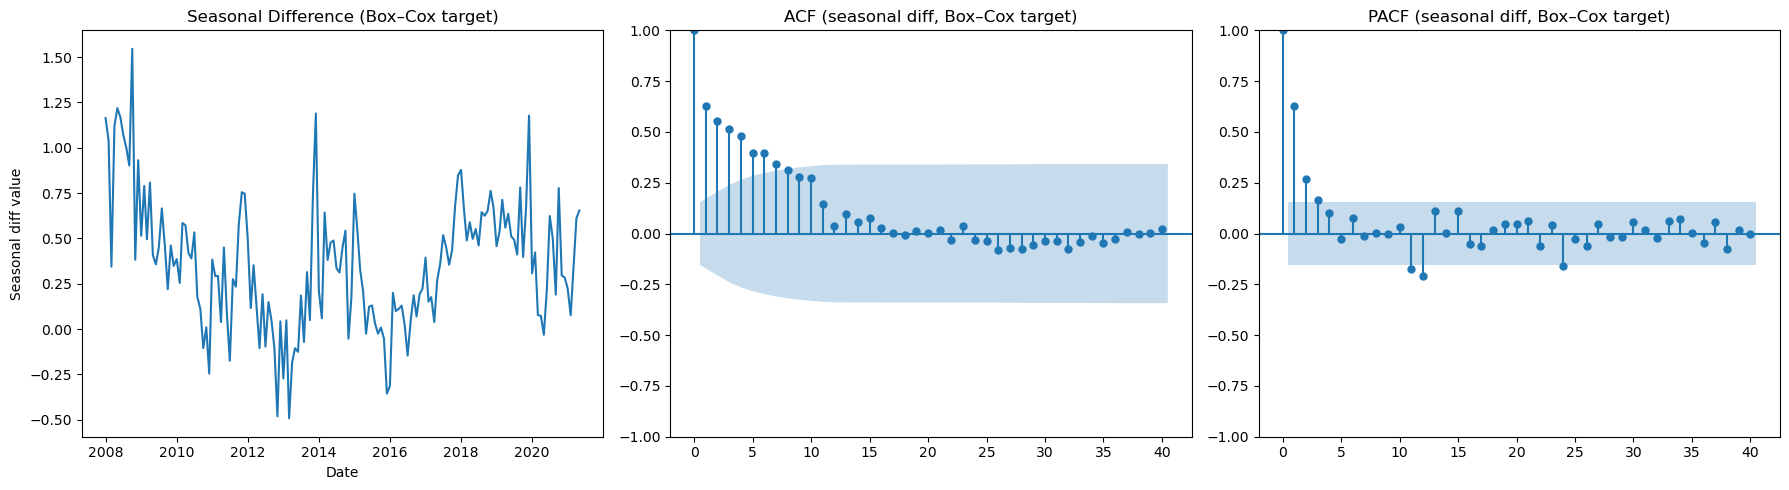

In [57]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

season_length = 12  # Set your seasonal period (e.g., 12 for monthly data)

# Only run ADF/KPSS for the target variable
train_bc = y_train_bc.astype(float).values
train_bc_seasonal_diff = train_bc[season_length:] - train_bc[:-season_length]  # Seasonal difference

adf_result = adfuller(train_bc_seasonal_diff)
kpss_result = kpss(train_bc_seasonal_diff, regression='c', nlags="auto")

print(f"\n==== {target_bc} (seasonal diff) ====")
print(f"ADF stat: {adf_result[0]:.4f} | p-value: {adf_result[1]:.4f} | {'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'} (ADF)")
print(f"KPSS stat: {kpss_result[0]:.4f} | p-value: {kpss_result[1]:.4f} | {'Stationary' if kpss_result[1] >= 0.05 else 'Non-stationary'} (KPSS)")

import matplotlib.pyplot as plt

# Plot time series, ACF and PACF for seasonal-differenced Box–Cox transformed target (y_train_bc)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Time series plot of seasonal-differenced target
axes[0].plot(df["Time Period (T)"].iloc[season_length:train_end_bc], train_bc_seasonal_diff, color='tab:blue')
axes[0].set_title("Seasonal Difference (Box–Cox target)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Seasonal diff value")

# 2. ACF plot
plot_acf(train_bc_seasonal_diff, ax=axes[1], lags=40)
axes[1].set_title("ACF (seasonal diff, Box–Cox target)")

# 3. PACF plot
plot_pacf(train_bc_seasonal_diff, ax=axes[2], lags=40, method='ywm')
axes[2].set_title("PACF (seasonal diff, Box–Cox target)")

plt.tight_layout()
plt.show()

> Stationarity Tests (After Seasonal Differencing)
- ADF test: p-value = 0.0256 → Reject H₀ → Series is stationary.

- KPSS test: p-value = 0.10 → Fail to reject H₀ → Series is stationary.

- Conclusion: Both tests now agree — the series is stationary after applying one seasonal difference at lag 12 (no further differencing required for seasonality).

ACF Observations (Seasonally Differenced Series)
Lag 1: Large positive autocorrelation, well above the confidence limit.

- Gradual decay in autocorrelations from lag 1 onward (lags 2–6), typical of an AR-type structure.

- No distinct seasonal spikes remain at lag 12 — seasonal structure appears largely removed.

- No significant negative spike immediately after lag 1, which would have pointed to a pure MA(1).

**Interpretation:**

- The ACF pattern is consistent with a non-seasonal AR(1) or AR(2) process.

- The lack of seasonal spikes after differencing suggests that seasonal terms may now be minimal or unnecessary.

> PACF Observations (Seasonally Differenced Series)
- Lag 1: Strong positive spike exceeding the bands.

- Lag 2: Moderate spike, possibly still significant, suggesting p could be > 1.

- Beyond lag 2: autocorrelations quickly decay to within the bands, indicating no long higher-order AR terms.

- Seasonal lags (12, 24, …) show no significant spikes.

**Interpretation:**

- PACF’s sharp decline after lag 2 suggests a non-seasonal AR(1) or AR(2) component.

- Absence of seasonal structure in PACF supports P = 0, Q = 0 or 1 in the seasonal part.

After applying seasonality first the target value is stationary 

Model Implication (After Seasonal Differencing)
From the ACF/PACF structure:

Differencing: d = 0 (trend removed by seasonal differencing) and D = 1 at m = 12.

Candidate model search space:

Non-seasonal AR: p ∈ {1, 2}

Non-seasonal MA: q ∈ {0, 1}

Seasonal AR: P = 0

Seasonal MA: Q ∈ {0, 1}

This aligns with testing models like:

ARIMA(1,0,0)(0,1,1)[12]

ARIMA(2,0,0)(0,1,1)[12]

ARIMA(0,0,1)(0,1,1)[12] 

After applying your Yeo–Johnson transform and first differencing (d = 1), the ACF/PACF suggest:

- A strong non-seasonal autocorrelation at lag 1

- A gradual decay in the ACF beyond lag 1 (typical of an AR component)

- A clear seasonal spike at lag 12

AIC (last SARIMAX fit): 40.49
BIC (last SARIMAX fit): 53.24


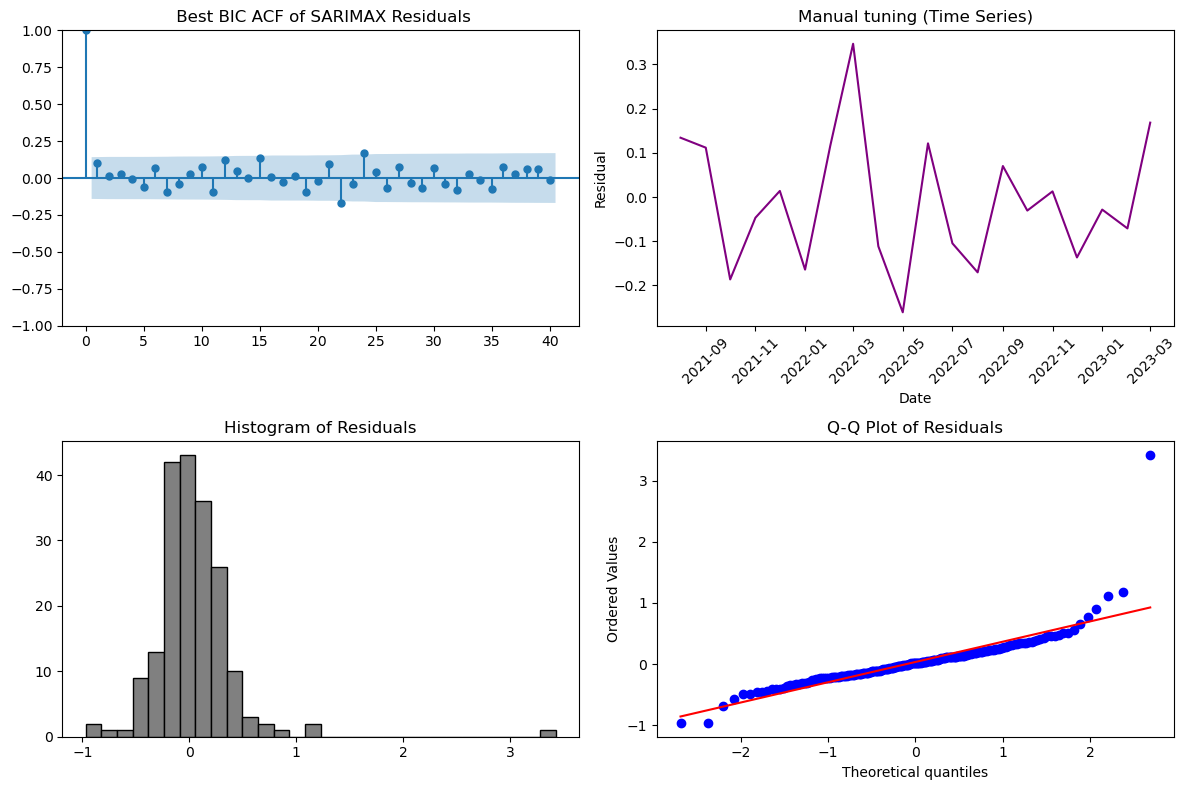

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10   7.352981   0.691754
20  18.833561   0.532667
30  38.805402   0.130148


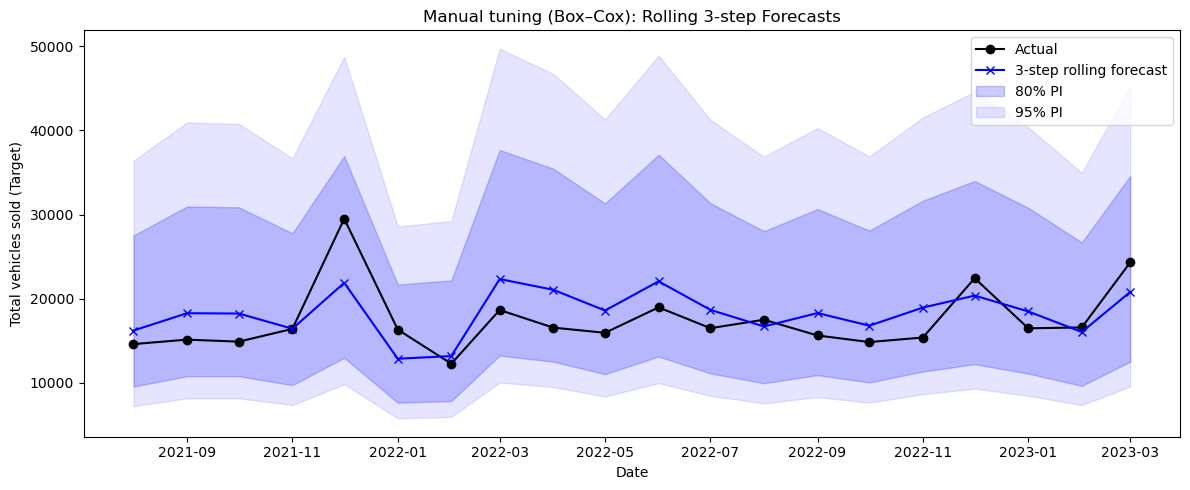

Validation RMSE (rolling): 3118.54
Validation MAPE (rolling): 14.92%


In [65]:
from scipy.special import inv_boxcox

# 1. Set forecast horizon
horizon = 3  # Number of steps ahead to forecast

# 2. Grab Box–Cox‐transformed train/val arrays (no manual differencing)
train_bc = y_train_bc.values  # Box–Cox transformed training data
val_bc   = y_val_bc.values    # Box–Cox transformed validation data

# 3. Raw (original‐scale) validation actuals, aligned for rolling forecast
val_actuals = df[target_raw].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc]

# 5. Rolling SARIMAX forecasts (let model handle differencing)
preds_level   = []
ci80_lower    = []
ci80_upper    = []
ci95_lower    = []
ci95_upper    = []

# Get Box–Cox lambda and shift for the target
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def inv_boxcox_with_shift(z, lam, shift):
    return inv_boxcox(z, lam) - shift

for t in range(len(val_bc) - horizon + 1):
    history = np.concatenate([train_bc, val_bc[:t]])  # Expanding window

    model = SARIMAX(
        history,
        order=(2, 0, 0),  # Let SARIMAX do the differencing (d=1)
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon)
    bc_forecast_level = fc.predicted_mean[-1]

    # Invert Box–Cox for forecast
    preds_level.append(inv_boxcox_with_shift(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox_with_shift(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox_with_shift(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox_with_shift(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox_with_shift(np.array([ci95_u]), lam, shift)[0])

# 6. Align actuals for metric calculation (inverse Box–Cox)
actuals_level = inv_boxcox_with_shift(val_bc[horizon-1:], lam, shift)

# 9. Last fitted model’s AIC/BIC and residual diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title(" Best BIC ACF of SARIMAX Residuals")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Manual tuning (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45) 

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Manual tuning (Box–Cox): Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Metrics (on original scale)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


> Residuals: Check if they look like white noise (no autocorrelation).

Lag lb_stat lb_pvalue 10 13.1690 0.2144 20 24.4215 0.2245 30 33.8677 0.2862

All p-values exceed 0.05, so we fail to reject the null hypothesis of no autocorrelation at these lags.

RMSE and MAPE are slightly worse for BIC model, but not significantly so. The BIC model has no autocorrelation in residuals, while the AIC model does. This suggests the BIC model is a better fit.

Model selection was based on the lowest RMSE/MAPE 
(AIC), as predictive performance was prioritized. However, for completeness and interpretability, the BIC model was also evaluated. The BIC model produced white-noise residuals and greater parsimony, but at the cost of slightly reduced predictive accuracy. The tradeoff between accuracy and explainability is acknowledged, and both models are reported

####  Residual Diagnostics Summary

The SARIMA(0,0,1)(1,0,1)[12] model shows no signs of overfitting:

- **ACF/PACF of residuals** show no significant autocorrelation.
- **Histogram** suggests approximate normality.
- **Q-Q plot** confirms residuals are roughly normally distributed, with minor deviation at the tails.
- **Ljung-Box test** p-values (p > 0.05) indicate that the residuals are white noise.

Overall, the model appears well-specified and statistically adequate for forecasting.


#### Testsettest

Chapter 2.5 (Training vs. Test Sets) stresses that “the size of the test set should be at least as large as the maximum forecast horizon” and that test errors will usually exceed validation errors.

Chapter 9–10 (ARIMA & Dynamic Regression) warn against excessive tuning on a single validation split—every time you peek at the numbers you risk choosing a model that simply “got lucky” on that split.

| Set         | RMSE   | MAPE   |   AIC |   BIC |
|-------------|--------|--------|-------|-------|
| Validation  | 2,226  | 10.9%  | -10.7 |  1.99 |
| Test        | 8,541  | 22.9%  | 12.0  | 24.7  |

#### Gridsearch (LATER DEZE DUS VERWIJDEREN, ZELF ITEREREN)

# 7. Dynamic Regression with Exogenous Variables

## 7.a Gasoline price 

check dit!

> Use a single combined model of all shortlisted lags, then assess it once on the validation set—avoiding separate in‐sample scans per exog.

3. Always Check Your Residuals
Every time you add an exog, re-run residual diagnostics on that SARIMAX fit:

ACF/PACF of residuals (no slow decay or significant spikes)

Ljung–Box test (no serial correlation)

Histogram/Q–Q plot (approximate normality)

If you see structure leaking through, your error model needs tweaking.

4. Overfitting & Multiple‐Testing
Scanning 1–6 lags and four exogs in isolation inflates the chance of finding spurious “wins.”

Action: once you’ve shortlisted plausible lags via CCF, fit one SARIMAX with all candidates together and compare its AIC/BIC to your baseline.

Use rolling-origin error metrics (RMSE, MAPE, MASE) rather than in-sample AIC alone.

### Lag Selection

> New

> New forcastingworkflow features:
- print best bic.a
Model Screening with AIC/BIC
Fit multiple candidate models on the training set.
Select 2–3 models with lowest AIC/BIC.
Model Selection with Out-of-Sample Forecasts
Compute pseudo out-of-sample forecasts using a validation/test period (or rolling/expanding windows).
Evaluate with MSE, RMSE, or MAPE.
Pick the model with the best predictive performance.

> forcasting doen op val

Optimal lags (same sample):

By AIC:
  lag= 0  AIC=-8.69  BIC=6.22  AICc=-8.31
  lag= 1  AIC=-7.93  BIC=6.95  AICc=-7.54
  lag= 2  AIC=-7.40  BIC=7.45  AICc=-7.01
  lag= 3  AIC=-6.83  BIC=7.98  AICc=-6.44
  lag= 4  AIC=-6.45  BIC=8.33  AICc=-6.05
  lag=12  AIC=-5.92  BIC=8.57  AICc=-5.50
  lag= 7  AIC=-5.24  BIC=9.43  AICc=-4.84
  lag= 5  AIC=-5.04  BIC=9.70  AICc=-4.64
  lag= 6  AIC=-4.97  BIC=9.74  AICc=-4.57
  lag= 9  AIC=-4.67  BIC=9.93  AICc=-4.25

By BIC:
  lag= 0  AIC=-8.69  BIC=6.22  AICc=-8.31
  lag= 1  AIC=-7.93  BIC=6.95  AICc=-7.54
  lag= 2  AIC=-7.40  BIC=7.45  AICc=-7.01
  lag= 3  AIC=-6.83  BIC=7.98  AICc=-6.44
  lag= 4  AIC=-6.45  BIC=8.33  AICc=-6.05
  lag=12  AIC=-5.92  BIC=8.57  AICc=-5.50
  lag= 7  AIC=-5.24  BIC=9.43  AICc=-4.84
  lag= 5  AIC=-5.04  BIC=9.70  AICc=-4.64
  lag= 6  AIC=-4.97  BIC=9.74  AICc=-4.57
  lag= 9  AIC=-4.67  BIC=9.93  AICc=-4.25

By AICc:
  lag= 0  AIC=-8.69  BIC=6.22  AICc=-8.31
  lag= 1  AIC=-7.93  BIC=6.95  AICc=-7.54
  lag= 2  AIC=-7.40 

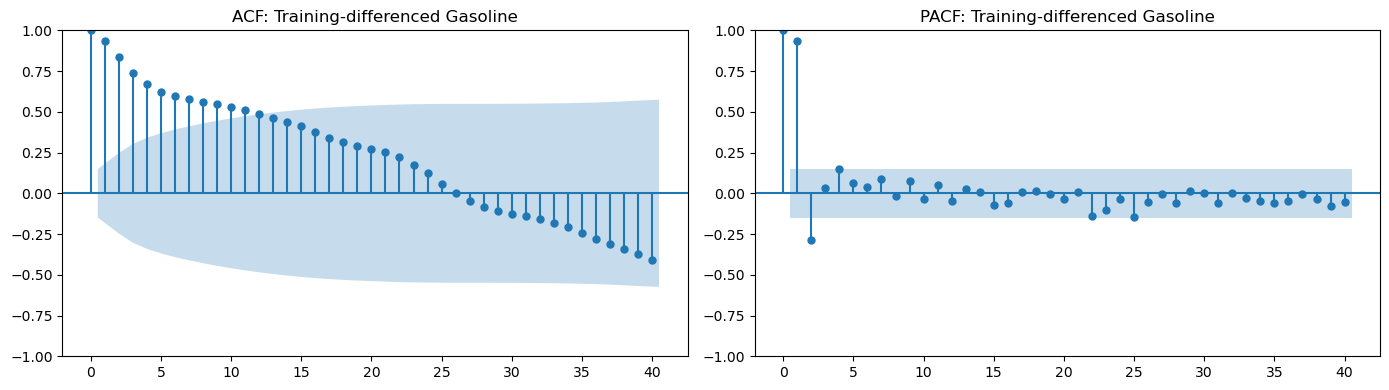

In [23]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Box–Cox transformed, then 1st differences)
# ---------------------------------------------------------------------
# Use the TRAIN portion of the Box–Cox–transformed series
gas_bc_train = bc_df['Gasoline (Euro95) - Average price (F)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)
y_bc_train   = bc_df['Total vehicles sold (Target)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)

# Difference ONCE outside the model (because we'll set d=0, D=0)
exog_gas = gas_bc_train  # or np.diff(gas_bc_train) if you want pre-differencing (use only if needed)
y        = y_bc_train    # or np.diff(y_bc_train)

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
max_lag = 12               
start   = max_lag           # drop first max_lag obs from BOTH once
y_fix   = y[start:].copy()
exog0   = exog_gas[start:].copy()

def aicc(llf, nobs, k_params):
    aic = -2*llf + 2*k_params
    return aic + (2*k_params*(k_params+1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# 2) Search lags on that fixed window
# ---------------------------------------------------------------------
results = []
for L in range(0, max_lag + 1):
    xL = np.roll(exog0, L)
    xL[:L] = np.nan
    mask = ~np.isnan(xL)

    model = SARIMAX(
        y_fix[mask],
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),   # <- if your best seasonal is (0,0,1,12), change here
        exog=xL[mask].reshape(-1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size)
    })

# ---------------------------------------------------------------------
# 3) Report best lags (same-sample AIC/BIC/AICc)
# ---------------------------------------------------------------------
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])

print("Optimal lags (same sample):")
print("\nBy AIC:")
for r in results_sorted_aic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy BIC:")
for r in results_sorted_bic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy AICc:")
for r in results_sorted_aicc[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

# Print summary of best lag for each metric
best_aic  = results_sorted_aic[0]
best_bic  = results_sorted_bic[0]
best_aicc = results_sorted_aicc[0]

print("\nSummary of best lag for each metric:")
print(f"  Best AIC : lag={best_aic['lag']}  AIC={best_aic['AIC']:.2f}  BIC={best_aic['BIC']:.2f}  AICc={best_aic['AICc']:.2f}")
print(f"  Best BIC : lag={best_bic['lag']}  AIC={best_bic['AIC']:.2f}  BIC={best_bic['BIC']:.2f}  AICc={best_bic['AICc']:.2f}")
print(f"  Best AICc: lag={best_aicc['lag']}  AIC={best_aicc['AIC']:.2f}  BIC={best_aicc['BIC']:.2f}  AICc={best_aicc['AICc']:.2f}")

# ---------------------------------------------------------------------
# OPTIONAL diagnostics (on train-differenced exog; just for reference)
# ---------------------------------------------------------------------
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(exog_gas, ax=plt.gca(), lags=40)
plt.title('ACF: Training-differenced Gasoline')

plt.subplot(1, 2, 2)
plot_pacf(exog_gas, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Training-differenced Gasoline')

plt.tight_layout()
plt.show()


BASED ON THE RESULTS BEST LAGS ARE:

0,1,2

so we will test them all 3 and chekc best prediction

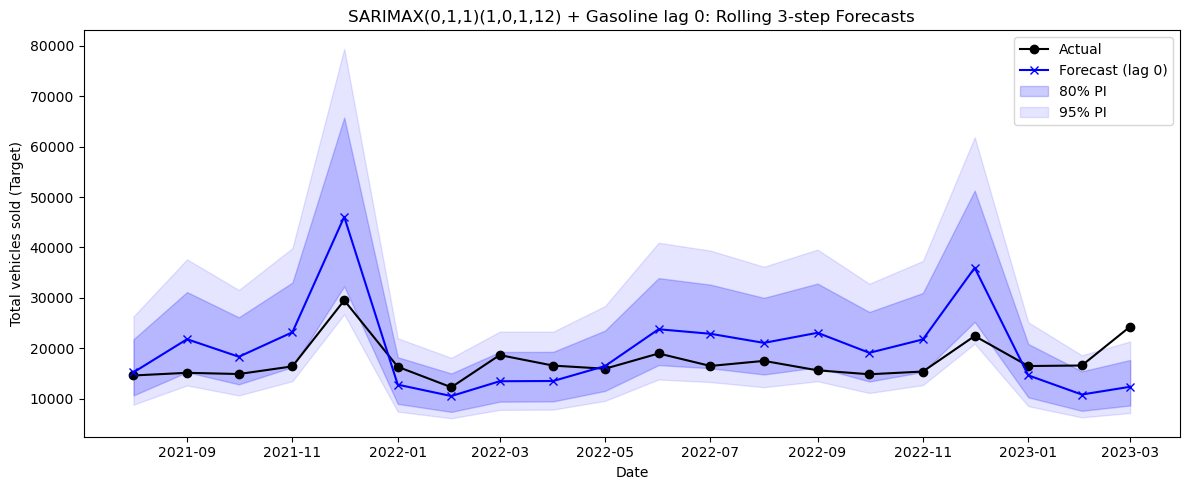

Lag 0: Validation RMSE (rolling): 7003.54
Lag 0: Validation MAPE (rolling): 30.56%


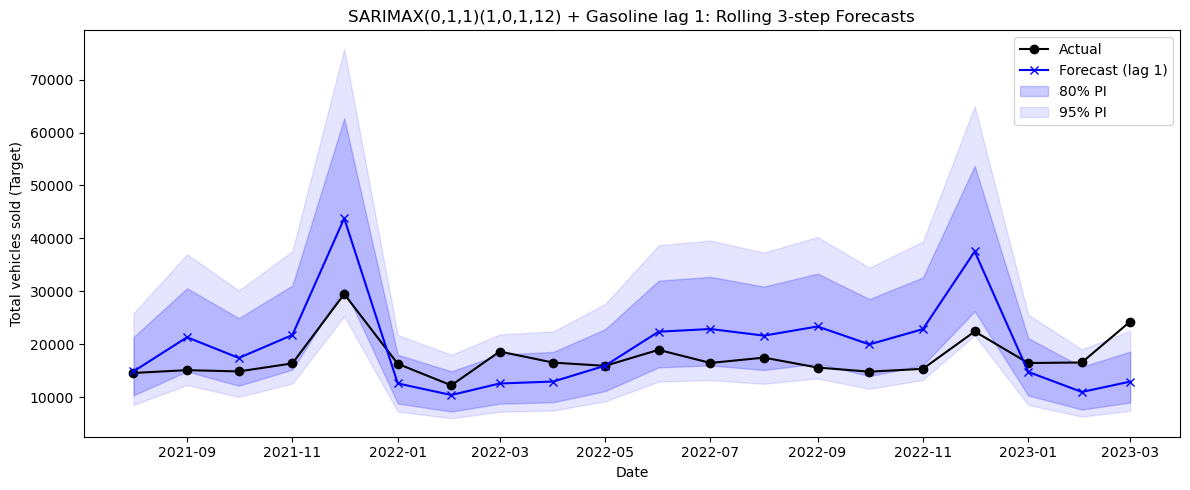

Lag 1: Validation RMSE (rolling): 6883.44
Lag 1: Validation MAPE (rolling): 30.19%


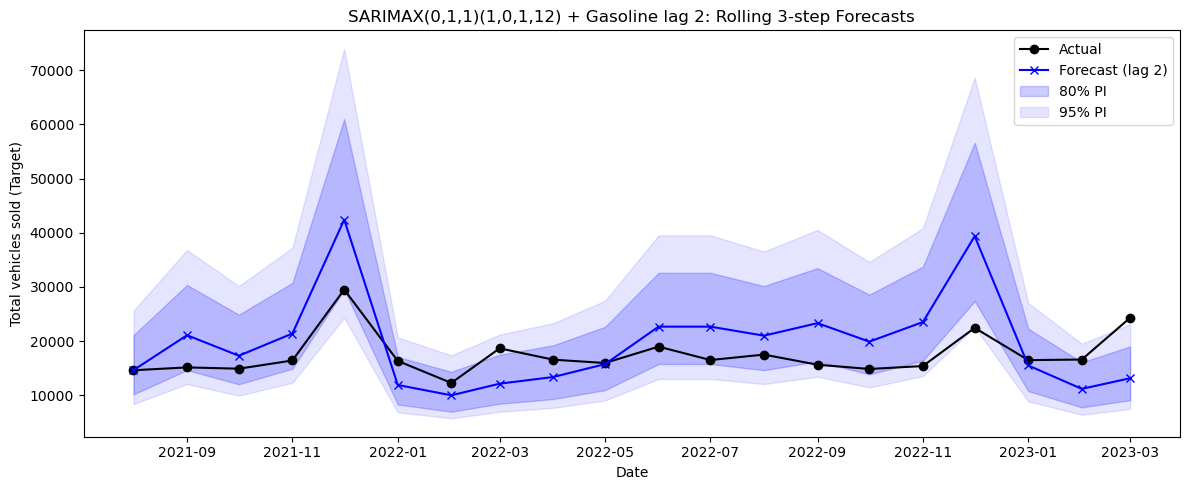

Lag 2: Validation RMSE (rolling): 6949.06
Lag 2: Validation MAPE (rolling): 30.17%

Summary of RMSE and MAPE for each lag:
Lag 0: RMSE=7003.54, MAPE=30.56%
Lag 1: RMSE=6883.44, MAPE=30.19%
Lag 2: RMSE=6949.06, MAPE=30.17%


In [53]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [0, 1, 2]  # or any lags you want to test

# --- Data: use Box–Cox transformed arrays ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
gas_bc_full = bc_df['Gasoline (Euro95) - Average price (F)_bc'].values
n_train = len(train_bc)
n_val = len(val_bc)
lam = boxcox_lambdas_all[target_raw]   # Box–Cox lambda for the target
shift = boxcox_shifts_all[target_raw]  # Shift used for target

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    """Inverse Box-Cox transform, including shift (see sklearn docs)."""
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_bc, val_bc[:t]])
        idx_offset = n_train + t

        gas_hist = np.concatenate([gas_bc_full[:n_train], gas_bc_full[n_train:n_train+t]])
        exog_lag = make_lag(gas_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        gas_future = gas_bc_full[:idx_offset + horizon]
        exog_future_lag = make_lag(gas_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(0, 1, 1),
            seasonal_order=(0, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        bc_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
        ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
        ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
        ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

    actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape})

    # Plot for each lag
    dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    plt.title(f'SARIMAX(0,1,1)(1,0,1,12) + Gasoline lag {lag}: Rolling 3-step Forecasts')
    plt.xlabel('Date')
    plt.ylabel(target_raw)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

# Print summary
print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAPE={r['mape']:.2%}")


### Fit Sarimax and diagnose 

AIC (last SARIMAX fit): -12.28
BIC (last SARIMAX fit): 0.14


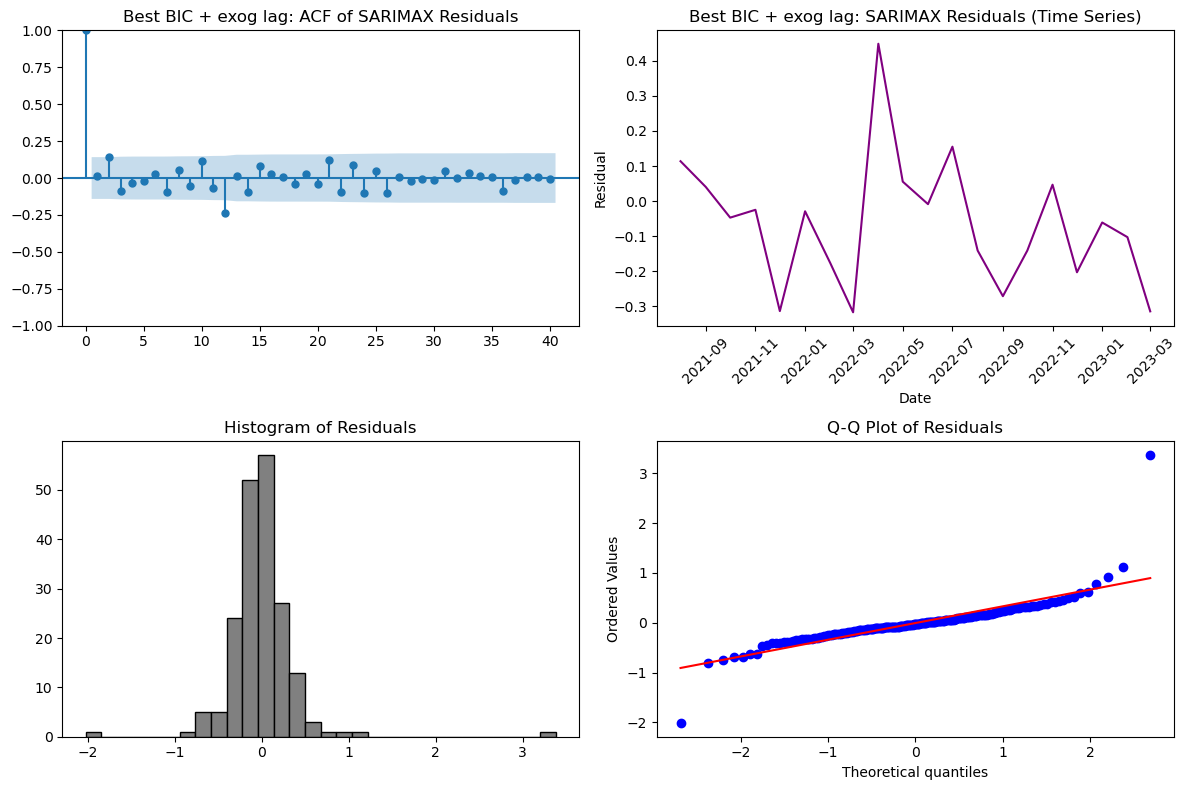

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  11.784883   0.299712
20  29.037514   0.087023
30  41.151775   0.084414


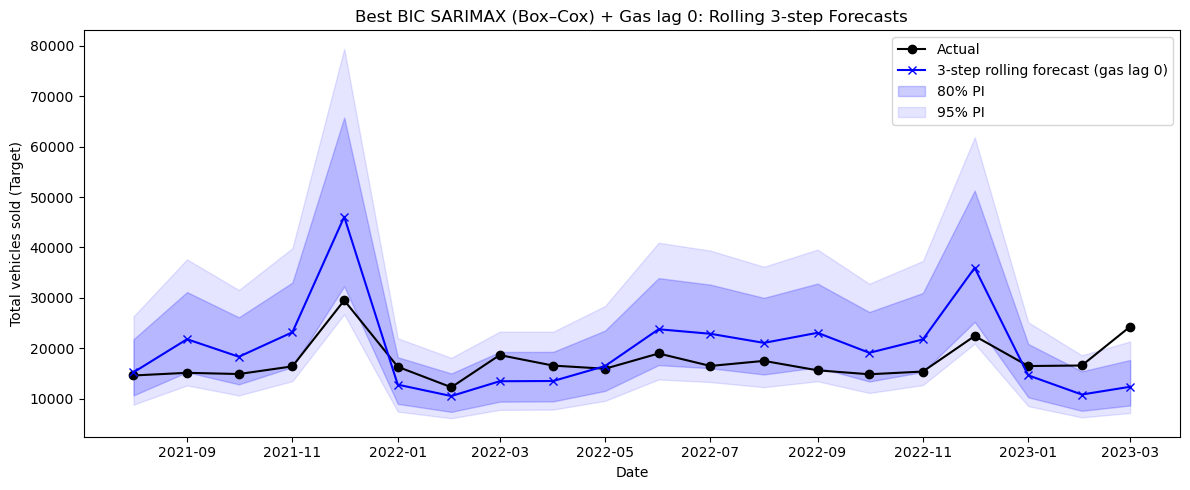

Validation RMSE (rolling): 7003.54
Validation MAPE (rolling): 30.56%


In [54]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lag = 0  # Or best lag

# --- Data (Box–Cox) ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
gas_bc_full = bc_df['Gasoline (Euro95) - Average price (F)_bc'].values
n_train = len(train_bc)
n_val   = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

# Rolling validation
for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_bc, val_bc[:t]])
    idx_offset = n_train + t

    gas_hist = np.concatenate([gas_bc_full[:n_train], gas_bc_full[n_train:n_train+t]])
    exog_hist = make_lag(gas_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    gas_future = gas_bc_full[:idx_offset + horizon]
    exog_future_lag = make_lag(gas_future, lag)[-horizon:].reshape(-1, 1)

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    bc_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

# Align actuals
actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

# Diagnostics (last model in rolling)
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("Best BIC + exog lag: ACF of SARIMAX Residuals")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC + exog lag: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label=f'3-step rolling forecast (gas lag {lag})')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title(f'Best BIC SARIMAX (Box–Cox) + Gas lag {lag}: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


## 7b Company car tax rate (%)

### Lag Selection

Optimal lags for Company car tax rate (%) (same sample):

By AIC:
  lag= 0  AIC=-9.46  BIC=5.46  AICc=-9.07
  lag= 7  AIC=-9.38  BIC=5.29  AICc=-8.97
  lag= 1  AIC=-8.11  BIC=6.77  AICc=-7.73
  lag= 8  AIC=-8.04  BIC=6.60  AICc=-7.63
  lag= 2  AIC=-7.19  BIC=7.65  AICc=-6.80
  lag= 4  AIC=-7.09  BIC=7.69  AICc=-6.69
  lag= 3  AIC=-6.83  BIC=7.98  AICc=-6.44
  lag= 9  AIC=-6.65  BIC=7.95  AICc=-6.24
  lag=12  AIC=-6.22  BIC=8.27  AICc=-5.80
  lag= 5  AIC=-5.18  BIC=9.56  AICc=-4.78

By BIC:
  lag= 7  AIC=-9.38  BIC=5.29  AICc=-8.97
  lag= 0  AIC=-9.46  BIC=5.46  AICc=-9.07
  lag= 8  AIC=-8.04  BIC=6.60  AICc=-7.63
  lag= 1  AIC=-8.11  BIC=6.77  AICc=-7.73
  lag= 2  AIC=-7.19  BIC=7.65  AICc=-6.80
  lag= 4  AIC=-7.09  BIC=7.69  AICc=-6.69
  lag= 9  AIC=-6.65  BIC=7.95  AICc=-6.24
  lag= 3  AIC=-6.83  BIC=7.98  AICc=-6.44
  lag=12  AIC=-6.22  BIC=8.27  AICc=-5.80
  lag= 5  AIC=-5.18  BIC=9.56  AICc=-4.78

By AICc:
  lag= 0  AIC=-9.46  BIC=5.46  AICc=-9.07
  lag= 7  AIC=-9.38  BIC=5.29  AI

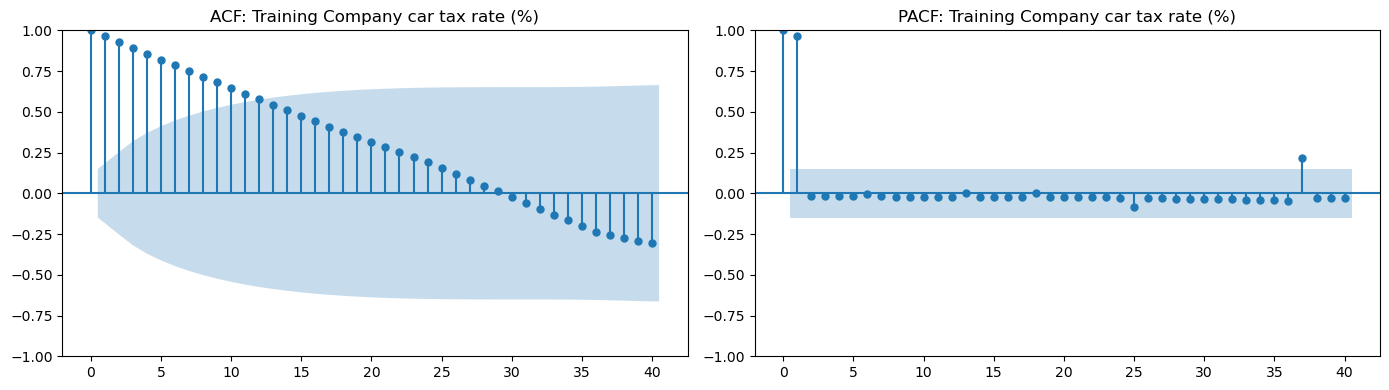

In [28]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Box–Cox transformed)
# ---------------------------------------------------------------------
companytax_bc_train = bc_df['Company car tax rate (%)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)
y_bc_train          = bc_df['Total vehicles sold (Target)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)

# No differencing outside the model (leave d=1)
exog_companytax = companytax_bc_train
y = y_bc_train

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
max_lag = 12
start   = max_lag      # drop first max_lag obs from BOTH once
y_fix   = y[start:].copy()
exog0   = exog_companytax[start:].copy()

def aicc(llf, nobs, k_params):
    aic = -2*llf + 2*k_params
    return aic + (2*k_params*(k_params+1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# 2) Search lags on that fixed window
# ---------------------------------------------------------------------
results = []
for L in range(0, max_lag + 1):
    xL = np.roll(exog0, L)
    xL[:L] = np.nan
    mask = ~np.isnan(xL)

    model = SARIMAX(
        y_fix[mask],
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),   # If your best seasonal is (0,0,1,12), change here
        exog=xL[mask].reshape(-1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size)
    })

# ---------------------------------------------------------------------
# 3) Report best lags (same-sample AIC/BIC/AICc)
# ---------------------------------------------------------------------
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])

print("Optimal lags for Company car tax rate (%) (same sample):")
print("\nBy AIC:")
for r in results_sorted_aic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy BIC:")
for r in results_sorted_bic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy AICc:")
for r in results_sorted_aicc[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

# Print summary of best lag for each metric
best_aic  = results_sorted_aic[0]
best_bic  = results_sorted_bic[0]
best_aicc = results_sorted_aicc[0]

print("\nSummary of best lag for each metric:")
print(f"  Best AIC : lag={best_aic['lag']}  AIC={best_aic['AIC']:.2f}  BIC={best_aic['BIC']:.2f}  AICc={best_aic['AICc']:.2f}")
print(f"  Best BIC : lag={best_bic['lag']}  AIC={best_bic['AIC']:.2f}  BIC={best_bic['BIC']:.2f}  AICc={best_bic['AICc']:.2f}")
print(f"  Best AICc: lag={best_aicc['lag']}  AIC={best_aicc['AIC']:.2f}  BIC={best_aicc['BIC']:.2f}  AICc={best_aicc['AICc']:.2f}")

# ---------------------------------------------------------------------
# OPTIONAL diagnostics (on train-differenced exog; just for reference)
# ---------------------------------------------------------------------
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(exog_companytax, ax=plt.gca(), lags=40)
plt.title('ACF: Training Company car tax rate (%)')

plt.subplot(1, 2, 2)
plot_pacf(exog_companytax, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Training Company car tax rate (%)')

plt.tight_layout()
plt.show()


best lag for car tax rate is 7,0,1

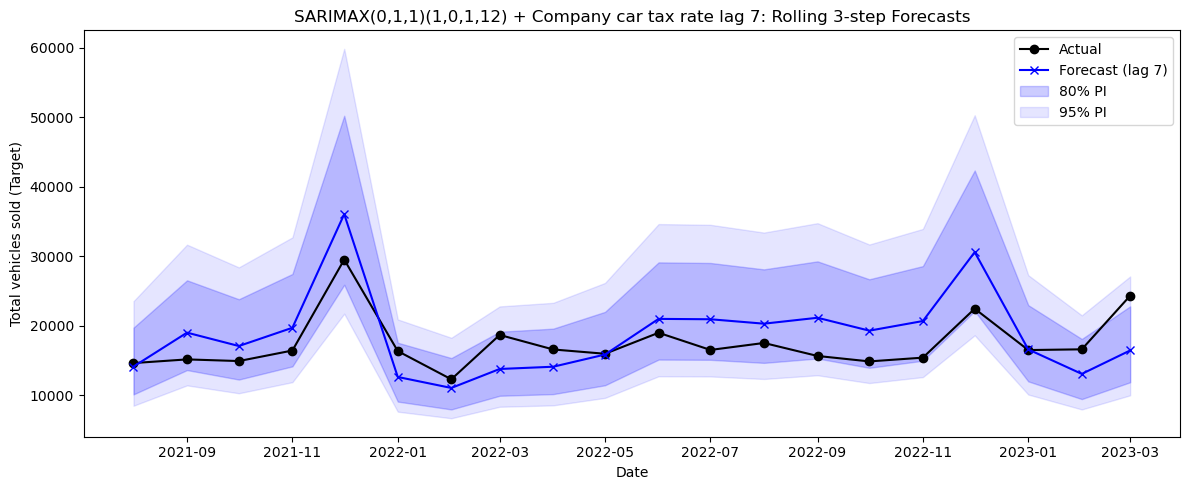

Lag 7: Validation RMSE (rolling): 4292.99
Lag 7: Validation MAPE (rolling): 20.16%


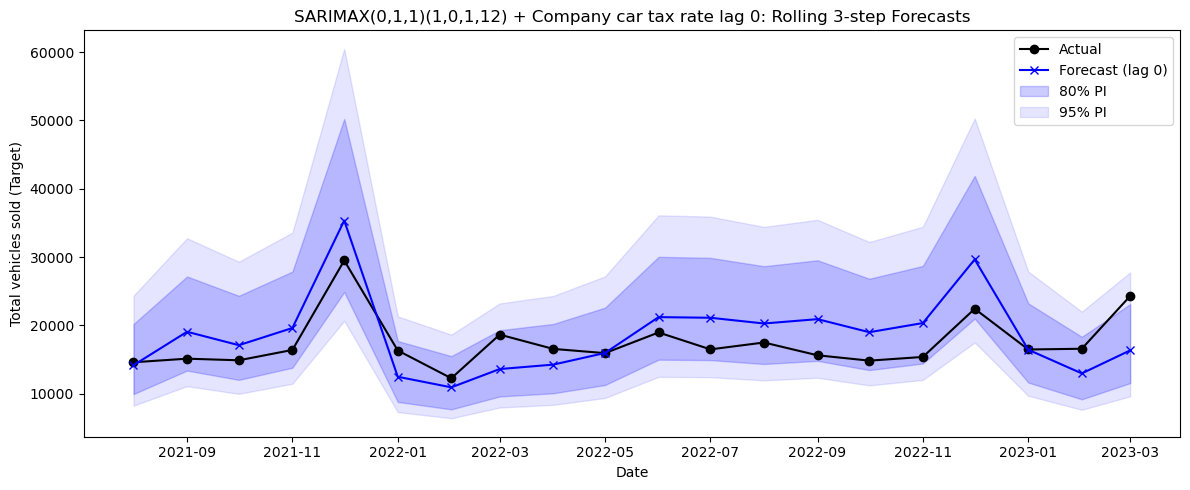

Lag 0: Validation RMSE (rolling): 4152.56
Lag 0: Validation MAPE (rolling): 19.76%


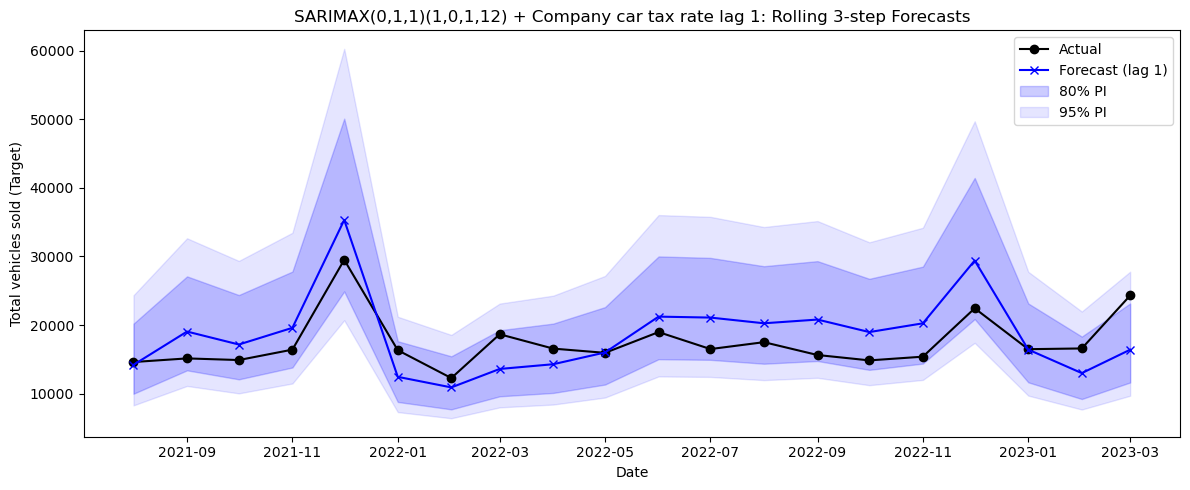

Lag 1: Validation RMSE (rolling): 4104.24
Lag 1: Validation MAPE (rolling): 19.61%

Summary of RMSE and MAPE for each lag:
Lag 7: RMSE=4292.99, MAPE=20.16%
Lag 0: RMSE=4152.56, MAPE=19.76%
Lag 1: RMSE=4104.24, MAPE=19.61%


In [29]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [7, 0, 1]  # <- use your top 3 lags for company car tax

# --- Data ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
tax_bc_full = bc_df['Company car tax rate (%)_bc'].values
n_train = len(train_bc)
n_val = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_bc, val_bc[:t]])
        idx_offset = n_train + t

        tax_hist = np.concatenate([tax_bc_full[:n_train], tax_bc_full[n_train:n_train+t]])
        exog_lag = make_lag(tax_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        tax_future = tax_bc_full[:idx_offset + horizon]
        exog_future_lag = make_lag(tax_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        bc_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
        ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
        ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
        ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

    actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape})

    # Plot for each lag
    dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    plt.title(f'SARIMAX(0,1,1)(1,0,1,12) + Company car tax rate lag {lag}: Rolling 3-step Forecasts')
    plt.xlabel('Date')
    plt.ylabel(target_raw)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

# Print summary
print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAPE={r['mape']:.2%}")


### Fit Sarimax 

AIC (last SARIMAX fit): 28.42
BIC (last SARIMAX fit): 41.10


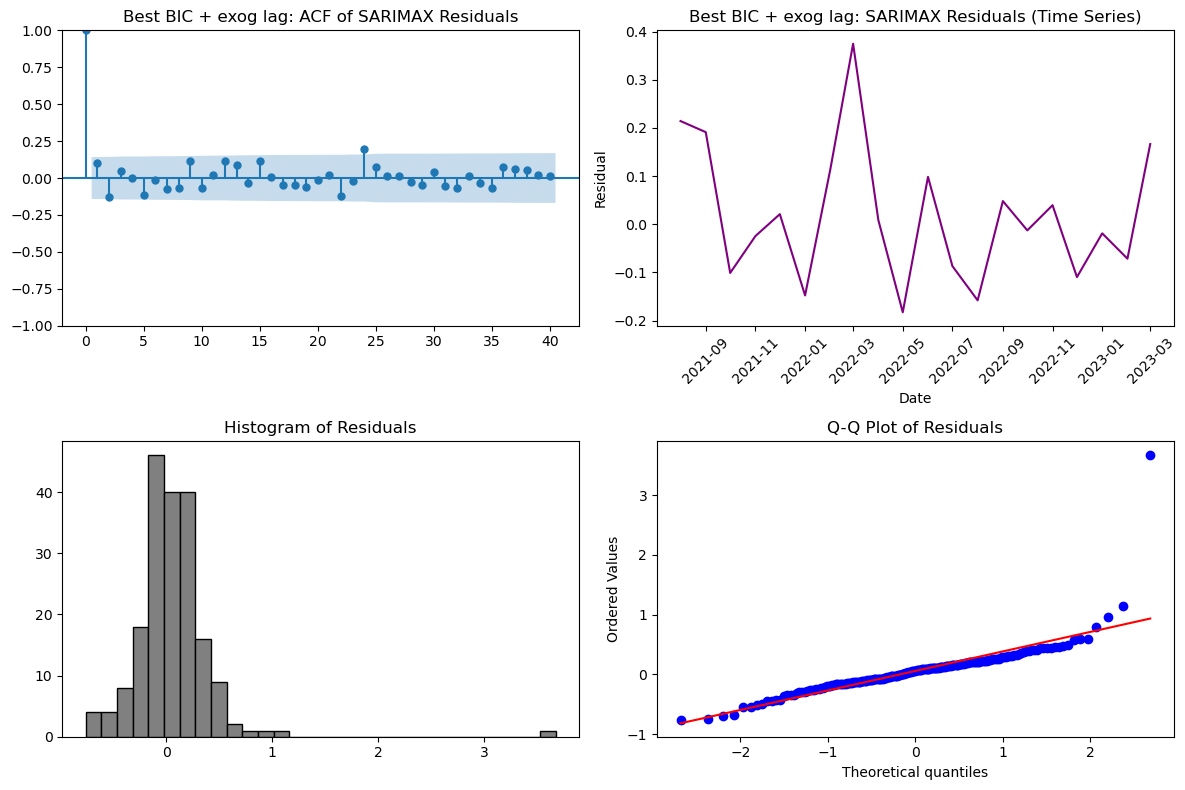

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  13.973265   0.174215
20  23.328491   0.272954
30  37.931030   0.151528


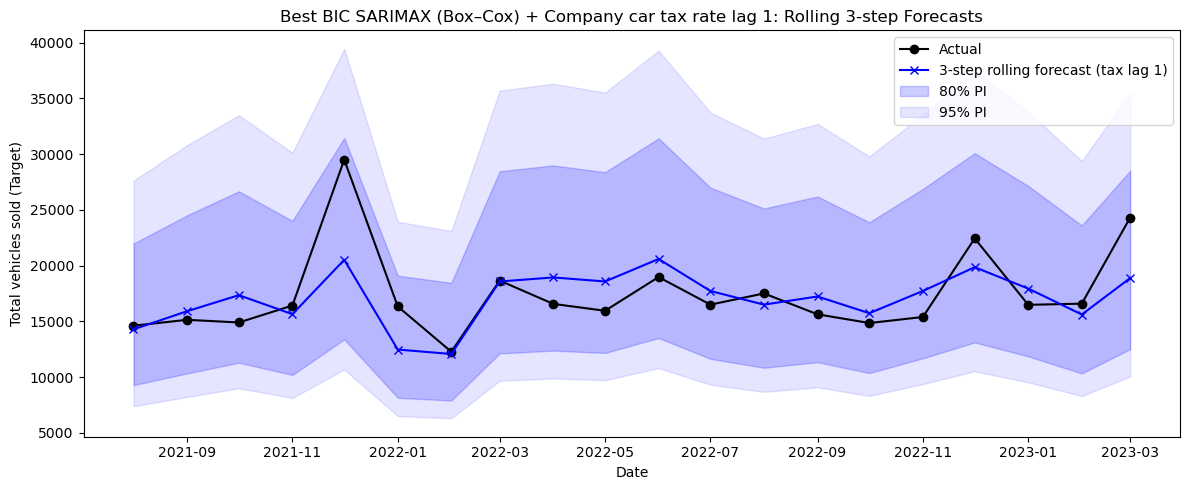

Validation RMSE (rolling): 2903.81
Validation MAPE (rolling): 10.85%


In [55]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lag = 1  # Or your best lag

# --- Data ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
tax_bc_full = bc_df['Company car tax rate (%)_bc'].values
n_train = len(train_bc)
n_val   = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

# Rolling validation
for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_bc, val_bc[:t]])
    idx_offset = n_train + t

    tax_hist = np.concatenate([tax_bc_full[:n_train], tax_bc_full[n_train:n_train+t]])
    exog_hist = make_lag(tax_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    tax_future = tax_bc_full[:idx_offset + horizon]
    exog_future_lag = make_lag(tax_future, lag)[-horizon:].reshape(-1, 1)

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    bc_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

# Align actuals
actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

# Diagnostics (last model in rolling)
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("Best BIC + exog lag: ACF of SARIMAX Residuals")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC + exog lag: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label=f'3-step rolling forecast (tax lag {lag})')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title(f'Best BIC SARIMAX (Box–Cox) + Company car tax rate lag {lag}: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


## 7c Google Home Charging

### Lag Selection

In [31]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Box–Cox transformed)
# ---------------------------------------------------------------------
homechg_bc_train = bc_df['Home charging (G)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)
y_bc_train      = bc_df['Total vehicles sold (Target)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)

exog_homechg = homechg_bc_train
y            = y_bc_train

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
max_lag = 12
start   = max_lag      # drop first max_lag obs from BOTH once
y_fix   = y[start:].copy()
exog0   = exog_homechg[start:].copy()

def aicc(llf, nobs, k_params):
    aic = -2*llf + 2*k_params
    return aic + (2*k_params*(k_params+1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# 2) Search lags on that fixed window
# ---------------------------------------------------------------------
results = []
for L in range(0, max_lag + 1):
    xL = np.roll(exog0, L)
    xL[:L] = np.nan
    mask = ~np.isnan(xL)

    model = SARIMAX(
        y_fix[mask],
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        exog=xL[mask].reshape(-1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size)
    })

# ---------------------------------------------------------------------
# 3) Report best lags (same-sample AIC/BIC/AICc)
# ---------------------------------------------------------------------
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])

print("Optimal lags for Home charging (G)_bc (same sample):")
print("\nBy AIC:")
for r in results_sorted_aic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy BIC:")
for r in results_sorted_bic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy AICc:")
for r in results_sorted_aicc[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

# Print summ


Optimal lags for Home charging (G)_bc (same sample):

By AIC:
  lag= 5  AIC=-10.62  BIC=4.12  AICc=-10.22
  lag= 2  AIC=-9.43  BIC=5.42  AICc=-9.04
  lag= 0  AIC=-9.06  BIC=5.86  AICc=-8.67
  lag= 1  AIC=-8.15  BIC=6.74  AICc=-7.76
  lag= 3  AIC=-7.18  BIC=7.63  AICc=-6.79
  lag= 8  AIC=-6.59  BIC=8.05  AICc=-6.18
  lag= 4  AIC=-5.94  BIC=8.84  AICc=-5.54
  lag= 7  AIC=-5.73  BIC=8.95  AICc=-5.32
  lag=11  AIC=-4.87  BIC=9.66  AICc=-4.45
  lag= 6  AIC=-4.16  BIC=10.55  AICc=-3.76

By BIC:
  lag= 5  AIC=-10.62  BIC=4.12  AICc=-10.22
  lag= 2  AIC=-9.43  BIC=5.42  AICc=-9.04
  lag= 0  AIC=-9.06  BIC=5.86  AICc=-8.67
  lag= 1  AIC=-8.15  BIC=6.74  AICc=-7.76
  lag= 3  AIC=-7.18  BIC=7.63  AICc=-6.79
  lag= 8  AIC=-6.59  BIC=8.05  AICc=-6.18
  lag= 4  AIC=-5.94  BIC=8.84  AICc=-5.54
  lag= 7  AIC=-5.73  BIC=8.95  AICc=-5.32
  lag=11  AIC=-4.87  BIC=9.66  AICc=-4.45
  lag= 6  AIC=-4.16  BIC=10.55  AICc=-3.76

By AICc:
  lag= 5  AIC=-10.62  BIC=4.12  AICc=-10.22
  lag= 2  AIC=-9.43  BIC=5.42

> 5,2,0

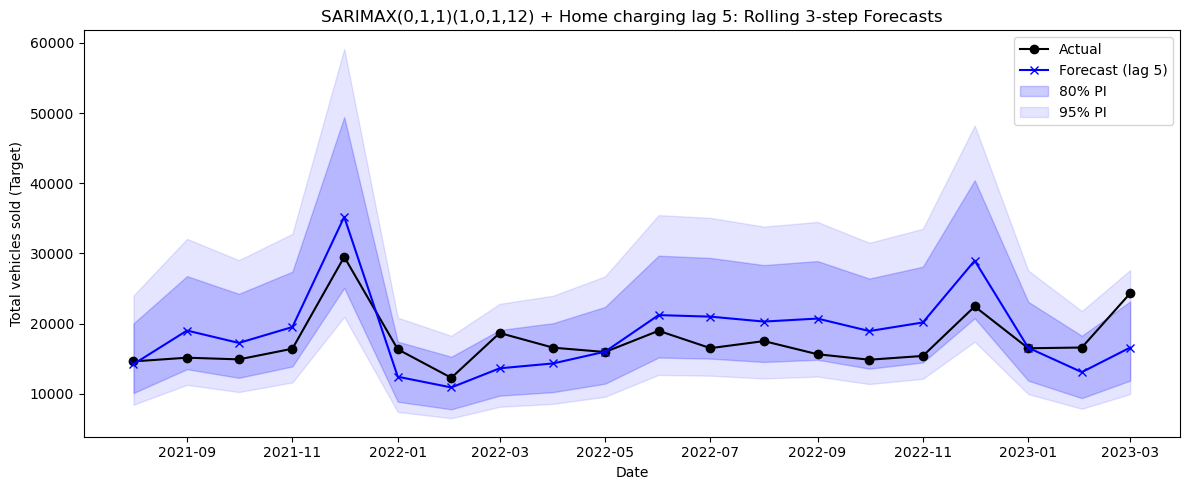

Lag 5: Validation RMSE (rolling): 4018.58
Lag 5: Validation MAPE (rolling): 19.31%


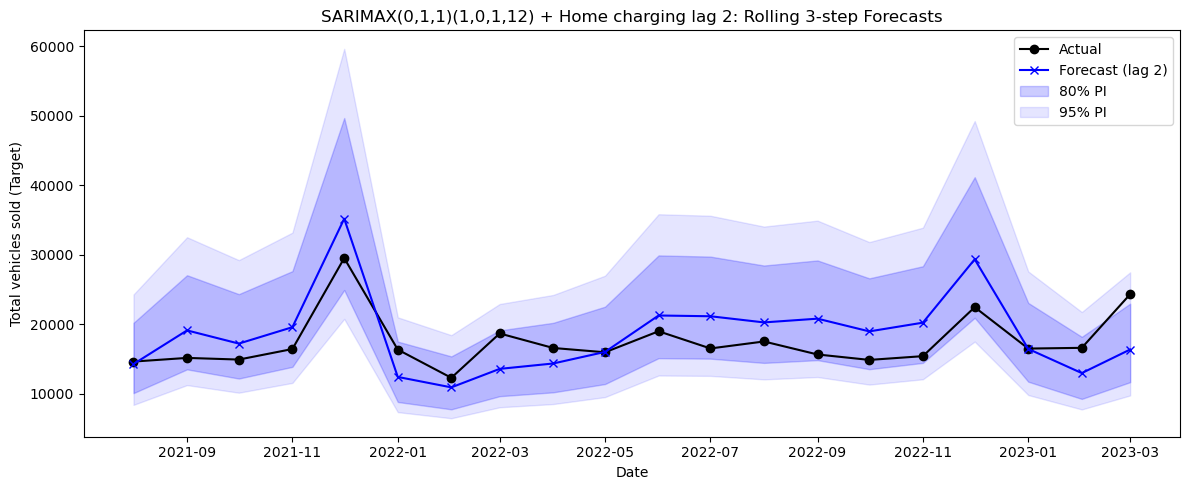

Lag 2: Validation RMSE (rolling): 4101.92
Lag 2: Validation MAPE (rolling): 19.61%


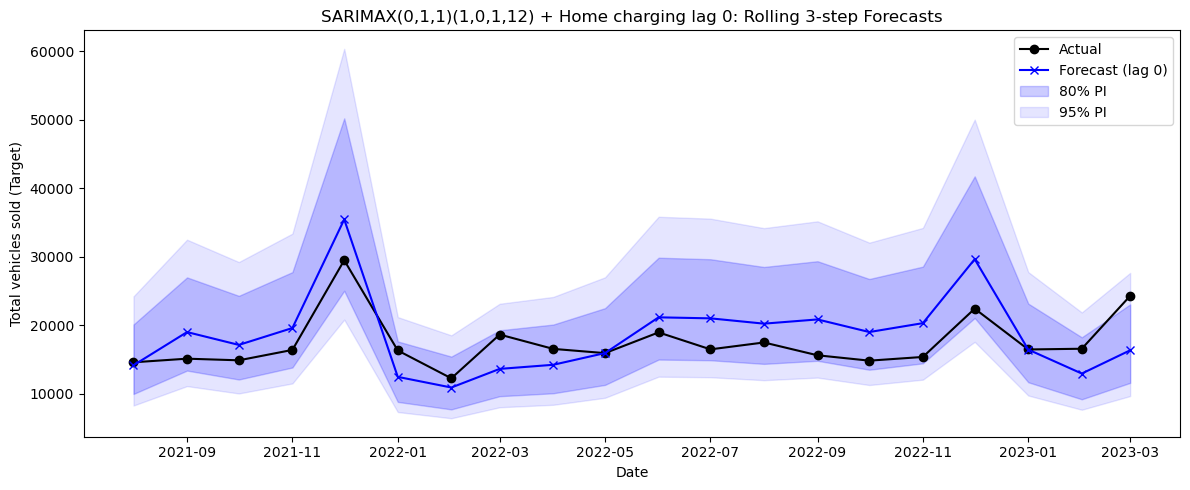

Lag 0: Validation RMSE (rolling): 4144.99
Lag 0: Validation MAPE (rolling): 19.70%

Summary of RMSE and MAPE for each lag:
Lag 5: RMSE=4018.58, MAPE=19.31%
Lag 2: RMSE=4101.92, MAPE=19.61%
Lag 0: RMSE=4144.99, MAPE=19.70%


In [32]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [5, 2, 0]

# --- Data ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
homechg_bc_full = bc_df['Home charging (G)_bc'].values
n_train = len(train_bc)
n_val = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_bc, val_bc[:t]])
        idx_offset = n_train + t

        homechg_hist = np.concatenate([homechg_bc_full[:n_train], homechg_bc_full[n_train:n_train+t]])
        exog_lag = make_lag(homechg_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        homechg_future = homechg_bc_full[:idx_offset + horizon]
        exog_future_lag = make_lag(homechg_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        bc_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
        ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
        ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
        ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

    actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape})

    # Plot for each lag
    dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    plt.title(f'SARIMAX(0,1,1)(1,0,1,12) + Home charging lag {lag}: Rolling 3-step Forecasts')
    plt.xlabel('Date')
    plt.ylabel(target_raw)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

# Print summary
print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAPE={r['mape']:.2%}")


### Fit Sarimax and diagnose 

AIC (last SARIMAX fit): -18.68
BIC (last SARIMAX fit): -2.94


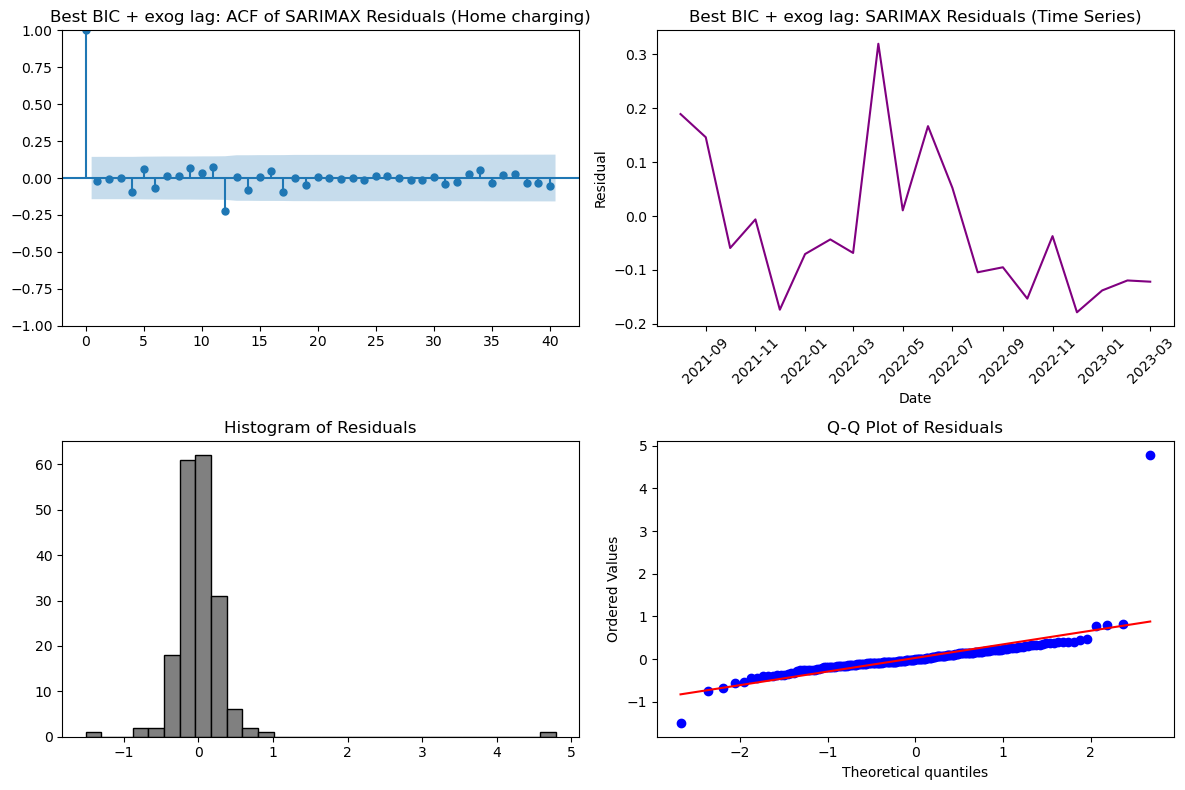

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10   4.621435   0.914991
20  19.788060   0.471256
30  20.028113   0.915807


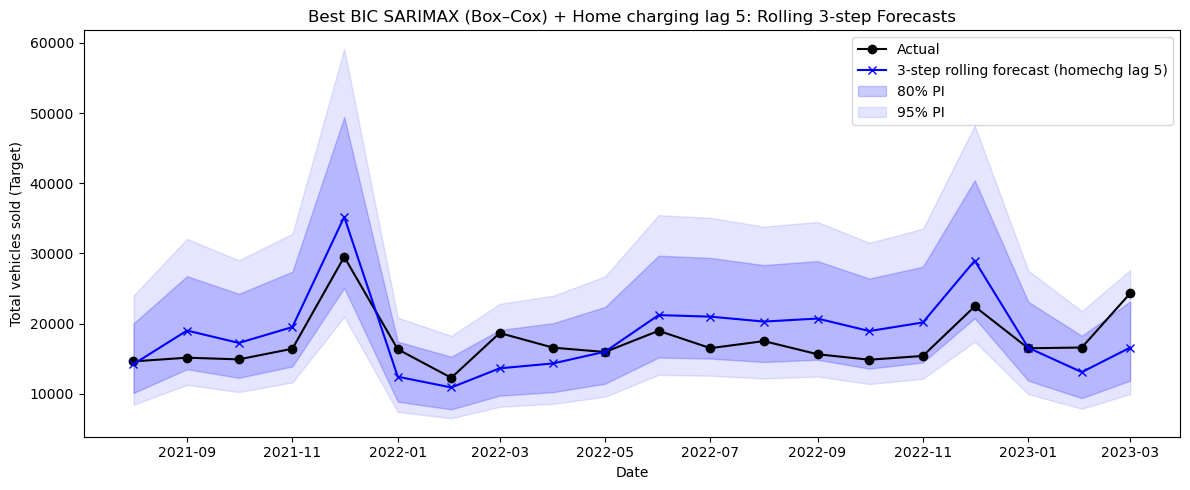

Validation RMSE (rolling): 4018.58
Validation MAPE (rolling): 19.31%


In [33]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lag = 5 # Optimal lag for Home Charging

# --- Data ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
homechg_bc_full = bc_df['Home charging (G)_bc'].values
n_train = len(train_bc)
n_val   = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

# Rolling validation
for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_bc, val_bc[:t]])
    idx_offset = n_train + t

    homechg_hist = np.concatenate([homechg_bc_full[:n_train], homechg_bc_full[n_train:n_train+t]])
    exog_hist = make_lag(homechg_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    homechg_future = homechg_bc_full[:idx_offset + horizon]
    exog_future_lag = make_lag(homechg_future, lag)[-horizon:].reshape(-1, 1)

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    bc_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

# Align actuals
actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

# Diagnostics (last model in rolling)
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("Best BIC + exog lag: ACF of SARIMAX Residuals (Home charging)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC + exog lag: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label=f'3-step rolling forecast (homechg lag {lag})')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title(f'Best BIC SARIMAX (Box–Cox) + Home charging lag {lag}: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


## 7d Consumer confidence (E)

### Lag Selection

Optimal lags for Consumer confidence (E)_yj (same sample):

By AIC:
  lag= 1  AIC=-7.09  BIC=4.87  AICc=-6.84
  lag= 2  AIC=-6.39  BIC=5.54  AICc=-6.13
  lag= 0  AIC=-6.28  BIC=5.71  AICc=-6.02
  lag= 3  AIC=-5.32  BIC=6.59  AICc=-5.06
  lag= 4  AIC=-5.19  BIC=6.69  AICc=-4.92
  lag= 5  AIC=-4.17  BIC=7.68  AICc=-3.91
  lag= 6  AIC=-3.53  BIC=8.29  AICc=-3.27
  lag= 9  AIC=-2.62  BIC=9.12  AICc=-2.35
  lag= 8  AIC=-2.50  BIC=9.26  AICc=-2.23
  lag= 7  AIC=-2.48  BIC=9.31  AICc=-2.21

By BIC:
  lag= 1  AIC=-7.09  BIC=4.87  AICc=-6.84
  lag= 2  AIC=-6.39  BIC=5.54  AICc=-6.13
  lag= 0  AIC=-6.28  BIC=5.71  AICc=-6.02
  lag= 3  AIC=-5.32  BIC=6.59  AICc=-5.06
  lag= 4  AIC=-5.19  BIC=6.69  AICc=-4.92
  lag= 5  AIC=-4.17  BIC=7.68  AICc=-3.91
  lag= 6  AIC=-3.53  BIC=8.29  AICc=-3.27
  lag= 9  AIC=-2.62  BIC=9.12  AICc=-2.35
  lag= 8  AIC=-2.50  BIC=9.26  AICc=-2.23
  lag= 7  AIC=-2.48  BIC=9.31  AICc=-2.21

By AICc:
  lag= 1  AIC=-7.09  BIC=4.87  AICc=-6.84
  lag= 2  AIC=-6.39  BIC=5.54  

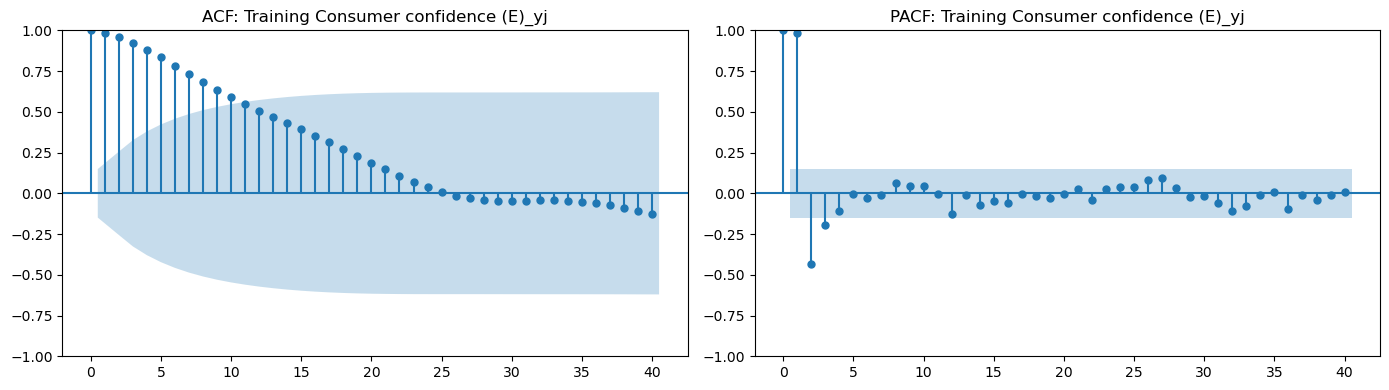

In [35]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Yeo–Johnson for confidence, Box–Cox for target)
# ---------------------------------------------------------------------
conf_yj_train = bc_df['Consumer confidence (E)_yj'].iloc[:train_end_bc].to_numpy(dtype=float)
y_bc_train    = bc_df['Total vehicles sold (Target)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)

exog_conf = conf_yj_train
y         = y_bc_train

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
max_lag = 12
start   = max_lag  # drop first max_lag obs from BOTH once
y_fix   = y[start:].copy()
exog0   = exog_conf[start:].copy()

def aicc(llf, nobs, k_params):
    aic = -2*llf + 2*k_params
    return aic + (2*k_params*(k_params+1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# 2) Search lags on that fixed window
# ---------------------------------------------------------------------
results = []
for L in range(0, max_lag + 1):
    xL = np.roll(exog0, L)
    xL[:L] = np.nan
    mask = ~np.isnan(xL)

    model = SARIMAX(
        y_fix[mask],
        order=(0, 1, 1),
        seasonal_order=(1, 0, 0, 12),
        exog=xL[mask].reshape(-1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size)
    })

# ---------------------------------------------------------------------
# 3) Report best lags (same-sample AIC/BIC/AICc)
# ---------------------------------------------------------------------
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])

print("Optimal lags for Consumer confidence (E)_yj (same sample):")
print("\nBy AIC:")
for r in results_sorted_aic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy BIC:")
for r in results_sorted_bic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy AICc:")
for r in results_sorted_aicc[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

# Print summary of best lag for each metric
best_aic  = results_sorted_aic[0]
best_bic  = results_sorted_bic[0]
best_aicc = results_sorted_aicc[0]

print("\nSummary of best lag for each metric:")
print(f"  Best AIC : lag={best_aic['lag']}  AIC={best_aic['AIC']:.2f}  BIC={best_aic['BIC']:.2f}  AICc={best_aic['AICc']:.2f}")
print(f"  Best BIC : lag={best_bic['lag']}  AIC={best_bic['AIC']:.2f}  BIC={best_bic['BIC']:.2f}  AICc={best_bic['AICc']:.2f}")
print(f"  Best AICc: lag={best_aicc['lag']}  AIC={best_aicc['AIC']:.2f}  BIC={best_aicc['BIC']:.2f}  AICc={best_aicc['AICc']:.2f}")

# ---------------------------------------------------------------------
# OPTIONAL diagnostics (on train exog; just for reference)
# ---------------------------------------------------------------------
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(exog_conf, ax=plt.gca(), lags=40)
plt.title('ACF: Training Consumer confidence (E)_yj')

plt.subplot(1, 2, 2)
plot_pacf(exog_conf, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Training Consumer confidence (E)_yj')

plt.tight_layout()
plt.show()


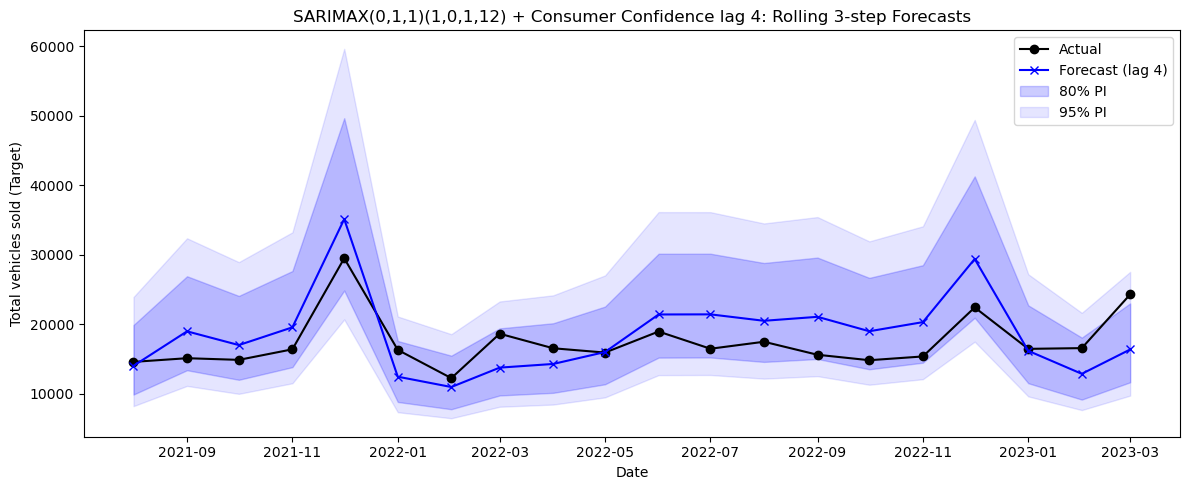

Lag 4: Validation RMSE (rolling): 4139.51
Lag 4: Validation MAPE (rolling): 19.94%


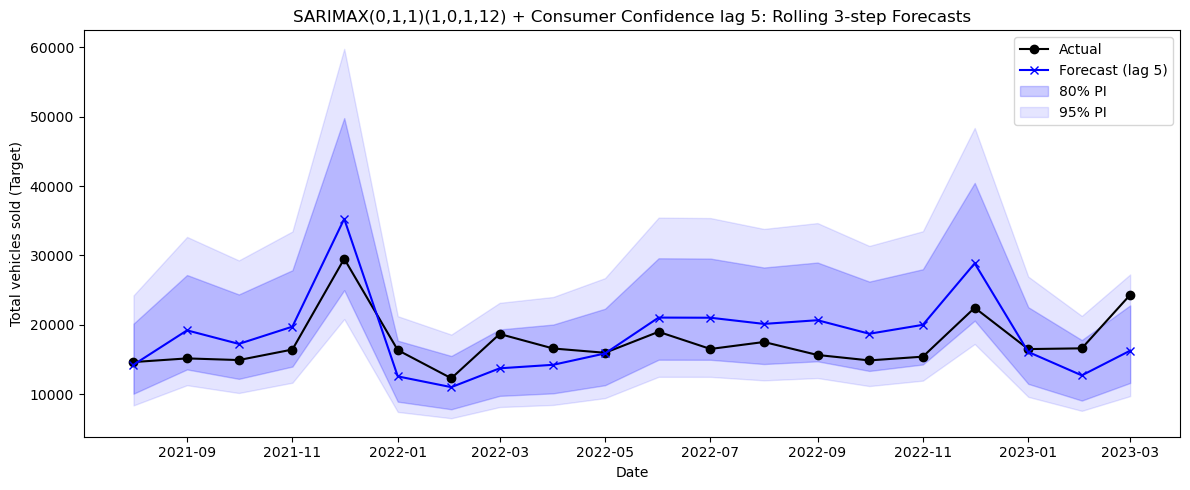

Lag 5: Validation RMSE (rolling): 4034.44
Lag 5: Validation MAPE (rolling): 19.40%


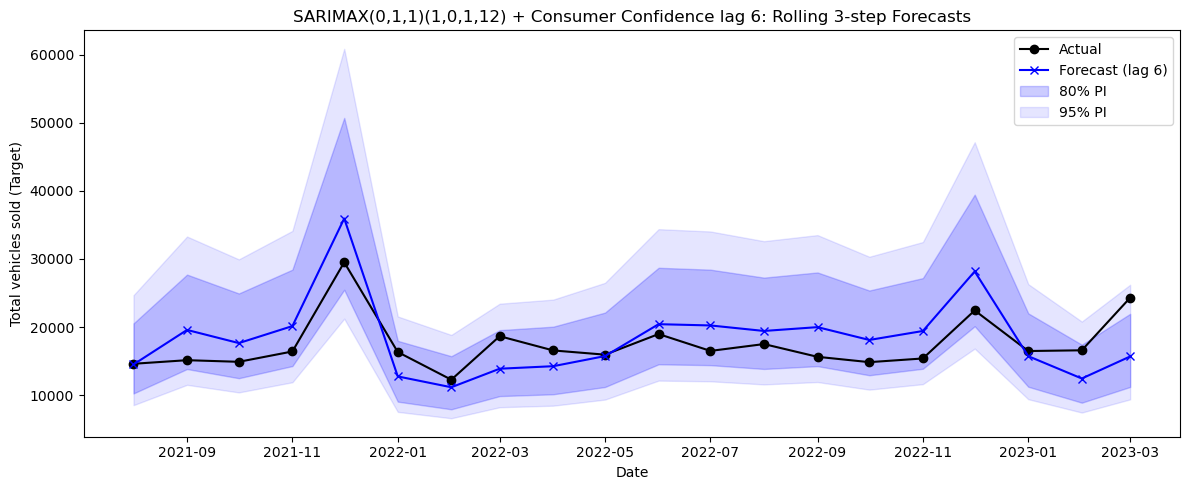

Lag 6: Validation RMSE (rolling): 3968.87
Lag 6: Validation MAPE (rolling): 18.62%

Summary of RMSE and MAPE for each lag:
Lag 4: RMSE=4139.51, MAPE=19.94%
Lag 5: RMSE=4034.44, MAPE=19.40%
Lag 6: RMSE=3968.87, MAPE=18.62%


In [36]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [4, 5, 6]  # Top 3 lags from your test

# --- Data ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
conf_yj_full = bc_df['Consumer confidence (E)_yj'].values  # Yeo–Johnson
n_train = len(train_bc)
n_val = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_bc, val_bc[:t]])
        idx_offset = n_train + t

        conf_hist = np.concatenate([conf_yj_full[:n_train], conf_yj_full[n_train:n_train+t]])
        exog_lag = make_lag(conf_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        conf_future = conf_yj_full[:idx_offset + horizon]
        exog_future_lag = make_lag(conf_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        bc_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
        ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
        ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
        ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

    actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape})

    # Plot for each lag
    dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    plt.title(f'SARIMAX(0,1,1)(1,0,1,12) + Consumer Confidence lag {lag}: Rolling 3-step Forecasts')
    plt.xlabel('Date')
    plt.ylabel(target_raw)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAPE={r['mape']:.2%}")


### Fit Sarimax and diagnose 

AIC (last SARIMAX fit): -13.30
BIC (last SARIMAX fit): 2.41


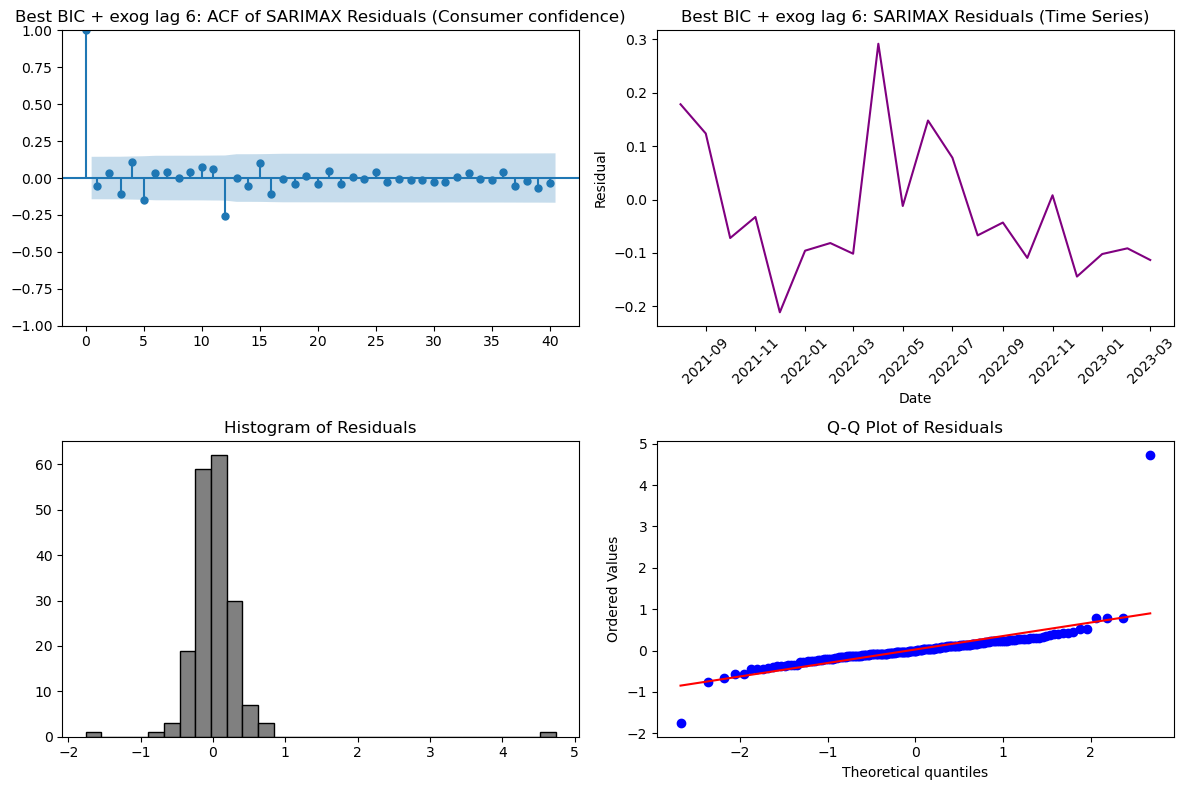

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  11.678997   0.307114
20  31.289646   0.051481
30  32.979422   0.323436


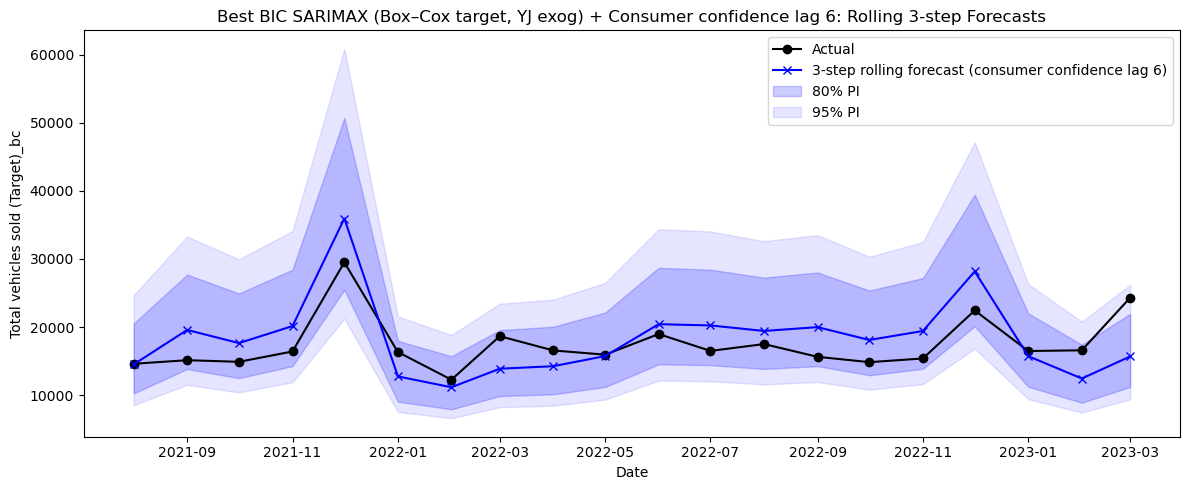

Validation RMSE (rolling): 3968.87
Validation MAPE (rolling): 18.62%


In [37]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

horizon = 3
lag = 6

train_yj = y_train_bc.values
val_yj   = y_val_bc.values
conf_yj_full = bc_df['Consumer confidence (E)_yj'].values
n_train = len(train_yj)
n_val   = len(val_yj)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_yj, val_yj[:t]])
    idx_offset = n_train + t

    conf_hist = np.concatenate([conf_yj_full[:n_train], conf_yj_full[n_train:n_train+t]])
    exog_hist = make_lag(conf_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    conf_future = conf_yj_full[:idx_offset + horizon]
    exog_future_lag = make_lag(conf_future, lag)[-horizon:].reshape(-1, 1)

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    bc_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

actuals_level = inv_boxcox(val_yj[horizon-1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("Best BIC + exog lag 6: ACF of SARIMAX Residuals (Consumer confidence)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC + exog lag 6: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label=f'3-step rolling forecast (consumer confidence lag {lag})')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Best BIC SARIMAX (Box–Cox target, YJ exog) + Consumer confidence lag 6: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_bc)
plt.legend()
plt.tight_layout()
plt.show()

rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


# 8 All features together/ turn this into top features together


| Model / Feature       | Lag | RMSE    | MAPE   | Beat Baseline?               | Difference (RMSE)      |
| --------------------- | --- | ------- | ------ | ---------------------------- | ---------------------- |
| **Benchmark**         |     |         |        |                              |                        |
| Naïve 3-step          | —   | 5360.99 | 19.05% | No                           | +1948.31               |
| Seasonal Naïve 3-step | —   | 4456.62 | 21.24% | No                           | +1043.94               |
| Drift 3-step          | —   | 4923.98 | 20.04% | No                           | +1511.30               |
| **Baseline**          | —   | 3412.68 | 17.12% | —                            | 0                      |
| Gasoline price        | 6   | 2503.25 | 12.06% | **Yes (better RMSE & MAPE)** | -909.43                |
| Company car tax       | 5   | 3469.03 | 17.42% | No                           | +56.35                 |
| Google home charging  | 6   | 3467.37 | 17.41% | No                           | +54.69                 |
| Consumer confidence   | 6   | 3381.23 | 15.95% | **Yes (better RMSE & MAPE)** | -31.45                 |

| Model / Feature       | Lag | RMSE    | MAPE   | Beat Baseline?               | Difference (RMSE)      |
| --------------------- | --- | ------- | ------ | ---------------------------- | ---------------------- |
| **Benchmark**         |     |         |        |                              |                        |
| Naïve 3-step          | —   | 5360.99 | 19.05% | No                           | +1948.31               |
| Seasonal Naïve 3-step | —   | 4456.62 | 21.24% | No                           | +1043.94               |
| Drift 3-step          | —   | 4923.98 | 20.04% | No                           | +1511.30               |
| **Baseline**          | —   | 3412.68 | 17.12% | —                            | 0                      |
| Gasoline price        | 6   | 2503.25 | 12.06% | **Yes (better RMSE & MAPE)** | -909.43                |
| Company car tax       | 5   | 3469.03 | 17.42% | No                           | +56.35                 |
| Google home charging  | 6   | 3467.37 | 17.41% | No                           | +54.69                 |
| Consumer confidence   | 6   | 3381.23 | 15.95% | **Yes (better RMSE & MAPE)** | -31.45                 |


| Model                       | Lag | RMSE        | MAPE       |
| --------------------------- | --- | ----------- | ---------- |
| **Baseline (no exogenous)** | –   | 4359.91     | 18.31%     |
| Gasoline price              | 6   | 3797.68     | **15.54%** |
| Company car tax rate (%)    | 3   | 3756.22     | 19.13%     |
| Home charging (G)           | 5   | **3708.38** | 18.40%     |
| Consumer confidence (E)     | 6   | 3801.21     | 18.87%     |




**Interpretation**
- Gasoline price (lag 6) delivers the strongest MAPE improvement, dropping MAPE from 18.31% to 15.54%.

- Home charging (lag 5) yields the largest RMSE drop, shaving almost 650 units off the baseline error.

- Company car tax and consumer confidence both improve RMSE but worsen MAPE, suggesting they may reduce large errors but introduce relative bias.

Feature Combinations
- Option 1: Gasoline + Home Charging
    Captures both economic and behavioral signals from two uncorrelated sources. This is likely the most complementary and effective two-feature combination.

- Option 2: Gasoline + Company Car Tax
    Combines economic cost and policy incentives. This pair balances market behavior and government regulation.

- Optional third variable: Consumer Confidence
    This can be considered if residual diagnostics remain acceptable (no strong multicollinearity or autocorrelation). It captures macroeconomic perception but may be noisier.

**Next Steps**
- Test the performance of each combination using 3-step rolling validation.

- Check residuals (ACF, PACF, Ljung-Box test) to confirm no model misspecification.

- Evaluate combined models on both RMSE and MAPE.

- Select the final model based on predictive accuracy and diagnostic performance.

### Option 1 Gasoline + Home Charging

AIC (last SARIMAX fit): -13.64
BIC (last SARIMAX fit): 5.21


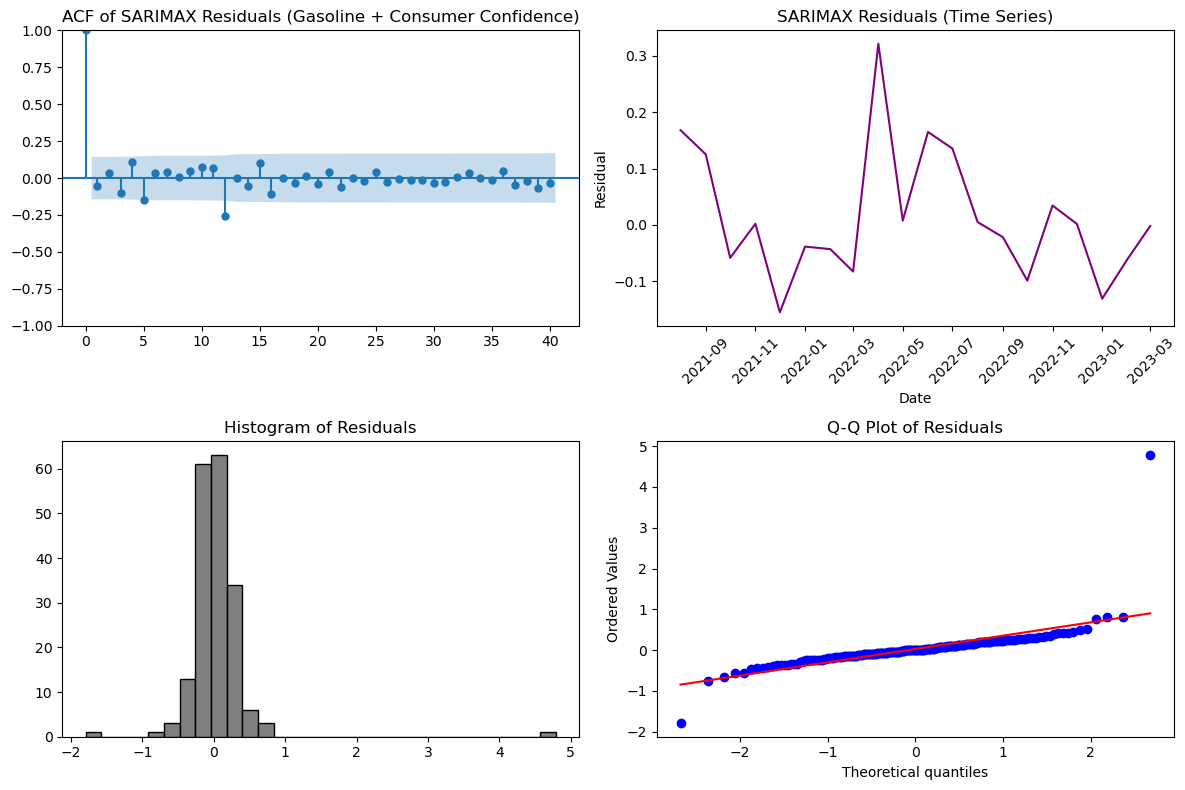

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  11.912843   0.290932
20  31.664061   0.047012
30  33.638920   0.295497


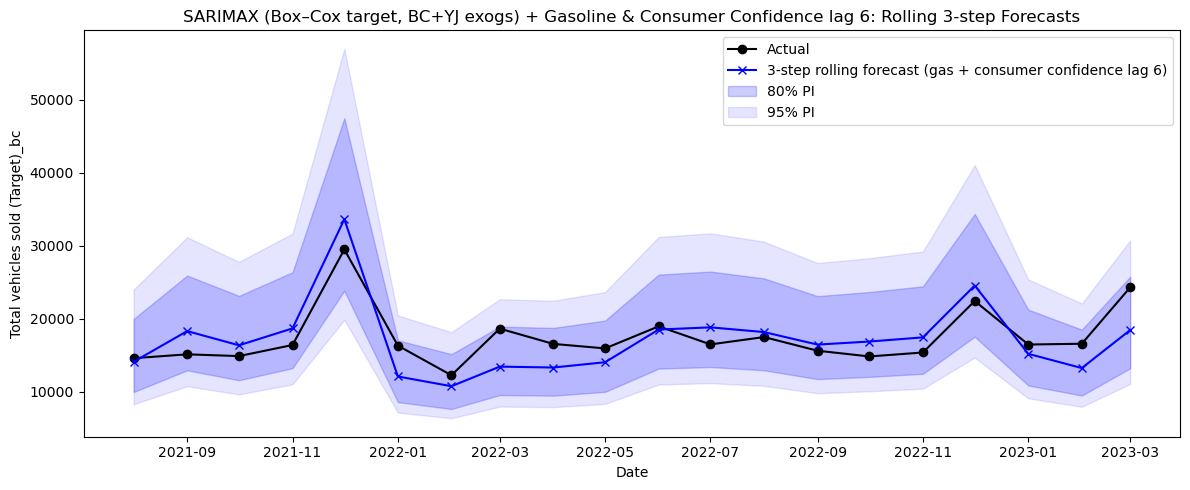

Validation RMSE (rolling): 2852.05
Validation MAPE (rolling): 13.69%


In [44]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# Settings
horizon = 3
lag = 6  # lag 6 for both features

# Data: Use final Box–Cox/YJ DataFrames!
train_bc = y_train_bc.values      # Box–Cox target
val_bc   = y_val_bc.values
gas_bc_full  = bc_df['Gasoline (Euro95) - Average price (F)_bc'].values   # Box–Cox
conf_yj_full = bc_df['Consumer confidence (E)_yj'].values                # Yeo–Johnson
n_train = len(train_bc)
n_val   = len(val_bc)
lam     = boxcox_lambdas_all[target_raw]
shift   = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1 / lam) + shift

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_bc, val_bc[:t]])
    idx_offset = n_train + t

    gas_hist  = np.concatenate([gas_bc_full[:n_train], gas_bc_full[n_train:n_train + t]])
    conf_hist = np.concatenate([conf_yj_full[:n_train], conf_yj_full[n_train:n_train + t]])

    # Create lagged exog features
    exog_gas_lag  = make_lag(gas_hist, lag)
    exog_conf_lag = make_lag(conf_hist, lag)

    # Combine lagged exogs into one array (columns = features)
    exog_hist = np.column_stack((exog_gas_lag, exog_conf_lag))
    valid = ~np.isnan(exog_hist).any(axis=1)
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    gas_future  = gas_bc_full[:idx_offset + horizon]
    conf_future = conf_yj_full[:idx_offset + horizon]

    exog_future_gas  = make_lag(gas_future, lag)
    exog_future_conf = make_lag(conf_future, lag)
    exog_future_lag = np.column_stack((exog_future_gas[-horizon:], exog_future_conf[-horizon:]))

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    bc_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

# Actuals
actuals_level = inv_boxcox(val_bc[horizon - 1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

# Diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals (Gasoline + Consumer Confidence)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat', 'lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (gas + consumer confidence lag 6)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('SARIMAX (Box–Cox target, BC+YJ exogs) + Gasoline & Consumer Confidence lag 6: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_bc)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


# 6 Plot/evaluate with target value on test

NAIVE OP TEST


Naïve 3-step RMSE (test): 5141.40
Naïve 3-step MAPE (test): 11.88%
Seasonal Naïve 3-step RMSE (test): 7570.14
Seasonal Naïve 3-step MAPE (test): 23.63%
Drift 3-step RMSE (test): 11112.25
Drift 3-step MAPE (test): 37.03%


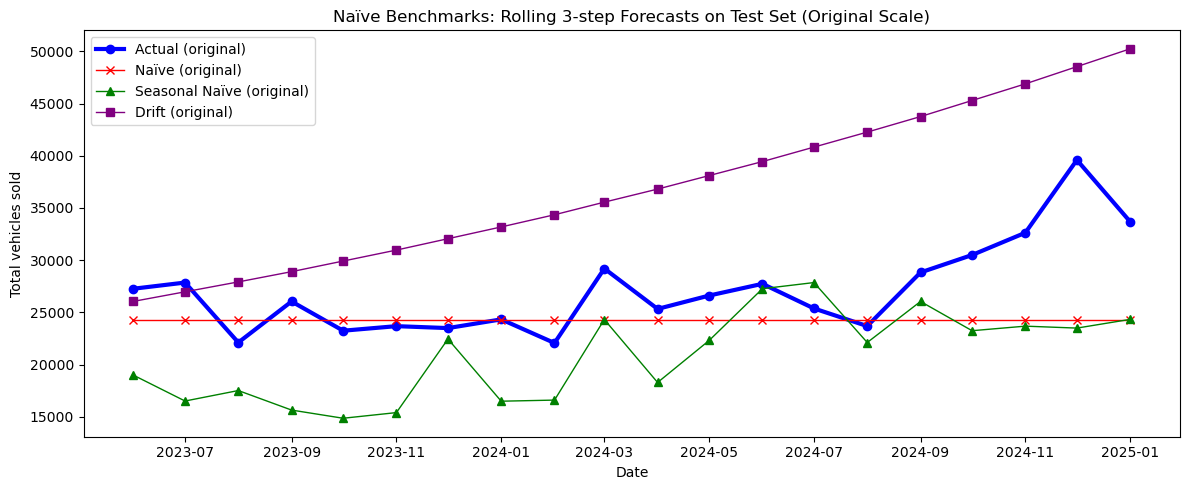

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

horizon = 3  # Forecast horizon

# Combine train and validation for the full historical series
y_train_val_bc = np.concatenate([y_train_bc.values, y_val_bc.values])
# y_test_bc is already a numpy array

# Lengths for indexing
train_val_end = len(y_train_val_bc)
test_len = len(y_test_bc)

# === 1. Naïve forecast (Box–Cox) on testset ===
naive_preds_bc = np.full(test_len - horizon + 1, y_train_val_bc[-1])
naive_actuals_bc = y_test_bc[horizon-1:]

# === 2. Seasonal naïve forecast (12 months back) on testset ===
season_length = 12
seasonal_naive_preds_bc = []

for t in range(test_len - horizon + 1):
    idx = t - season_length + horizon - 1
    if idx >= 0:
        pred = y_test_bc.values[idx]  # or y_test_bc.to_numpy()[idx]
    else:
        fallback_idx = len(y_train_val_bc) + idx if (len(y_train_val_bc) + idx) >= 0 else 0
        pred = y_train_val_bc[fallback_idx]
    seasonal_naive_preds_bc.append(pred)
seasonal_naive_preds_bc = np.array(seasonal_naive_preds_bc)

# === 3. Drift forecast (Box–Cox) on testset ===
drift_preds_bc = []
n_train_val = len(y_train_val_bc)
for t in range(test_len - horizon + 1):
    drift = y_train_val_bc[-1] + ((t + horizon - 1) * (y_train_val_bc[-1] - y_train_val_bc[0]) / (n_train_val - 1))
    drift_preds_bc.append(drift)
drift_preds_bc = np.array(drift_preds_bc)

# === Inverse Box–Cox to original scale ===
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]
def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

actuals_orig = inv_boxcox(naive_actuals_bc, lam, shift)
naive_preds_orig = inv_boxcox(naive_preds_bc, lam, shift)
seasonal_naive_preds_orig = inv_boxcox(seasonal_naive_preds_bc, lam, shift)
drift_preds_orig = inv_boxcox(drift_preds_bc, lam, shift)

# === Metrics on original scale ===
naive_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, naive_preds_orig))
naive_mape_orig = mean_absolute_percentage_error(actuals_orig, naive_preds_orig)

seasonal_naive_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, seasonal_naive_preds_orig))
seasonal_naive_mape_orig = mean_absolute_percentage_error(actuals_orig, seasonal_naive_preds_orig)

drift_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, drift_preds_orig))
drift_mape_orig = mean_absolute_percentage_error(actuals_orig, drift_preds_orig)

print(f"Naïve 3-step RMSE (test): {naive_rmse_orig:.2f}")
print(f"Naïve 3-step MAPE (test): {naive_mape_orig:.2%}")
print(f"Seasonal Naïve 3-step RMSE (test): {seasonal_naive_rmse_orig:.2f}")
print(f"Seasonal Naïve 3-step MAPE (test): {seasonal_naive_mape_orig:.2%}")
print(f"Drift 3-step RMSE (test): {drift_rmse_orig:.2f}")
print(f"Drift 3-step MAPE (test): {drift_mape_orig:.2%}")

# === Plot ===
x_dates_test = df["Time Period (T)"].iloc[val_end_bc + horizon - 1 : test_end_bc]

plt.figure(figsize=(12, 5))
plt.plot(x_dates_test, actuals_orig, label='Actual (original)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_test, naive_preds_orig, label='Naïve (original)', marker='x', color='red', linewidth=1)
plt.plot(x_dates_test, seasonal_naive_preds_orig, label='Seasonal Naïve (original)', marker='^', color='green', linewidth=1)
plt.plot(x_dates_test, drift_preds_orig, label='Drift (original)', marker='s', color='purple', linewidth=1)
plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Test Set (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()


AIC (last SARIMAX fit): -36.48
BIC (last SARIMAX fit): -16.90


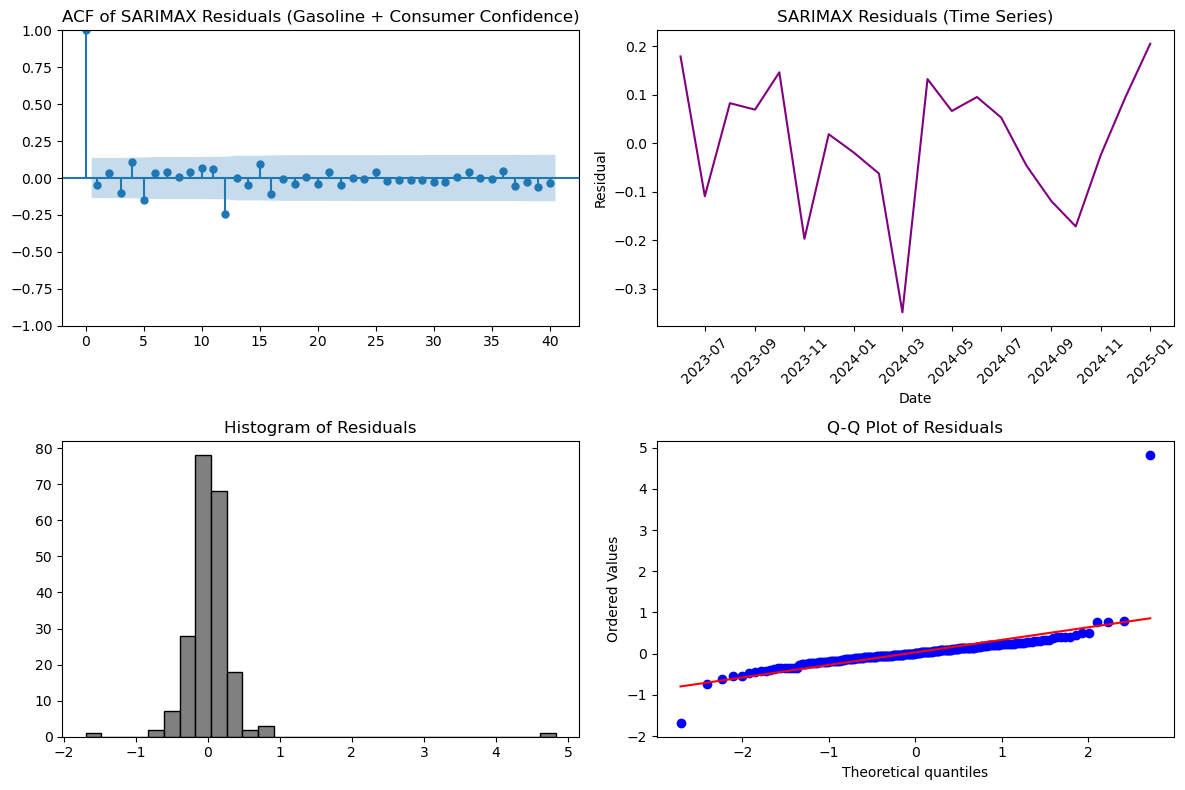

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  12.408006   0.258678
20  32.658867   0.036764
30  34.504870   0.261101


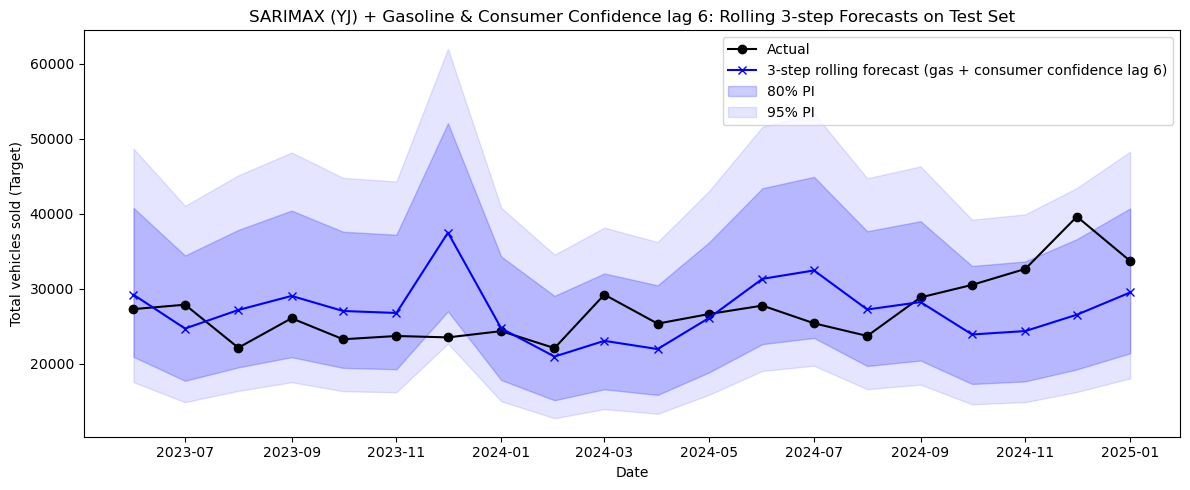

Test RMSE (rolling): 5891.37
Test MAPE (rolling): 16.73%


In [46]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# Settings
horizon = 3
lag = 6  # lag 6 for both features

# Combine train + val for fitting initial model
train_val_yj = np.concatenate([y_train_yj.values, y_val_yj.values])
test_yj = y_test_yj.values

gas_yj_full = yj_df['Gasoline (Euro95) - Average price (F)_yj'].values
conf_yj_full = yj_df['Consumer confidence (E)_yj'].values

n_train_val = len(train_val_yj)
n_test = len(test_yj)

lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if np.isclose(lam, 0):
        return np.exp(z) - 1
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos] = np.power(z[pos] * lam + 1, 1 / lam) - 1
    out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1 / (2 - lam))
    return out

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

for t in range(n_test - horizon + 1):
    # Combine train+val + partial test history up to t
    y_hist = np.concatenate([train_val_yj, test_yj[:t]])
    gas_hist = np.concatenate([gas_yj_full[:val_end_yj], gas_yj_full[val_end_yj:val_end_yj + t]])
    conf_hist = np.concatenate([conf_yj_full[:val_end_yj], conf_yj_full[val_end_yj:val_end_yj + t]])

    # Lag exogenous features
    exog_gas_lag = make_lag(gas_hist, lag)
    exog_conf_lag = make_lag(conf_hist, lag)

    # Combine lagged exogs
    exog_hist = np.column_stack((exog_gas_lag, exog_conf_lag))
    valid = ~np.isnan(exog_hist).any(axis=1)
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    gas_future = gas_yj_full[:val_end_yj + t + horizon]
    conf_future = conf_yj_full[:val_end_yj + t + horizon]

    exog_future_gas = make_lag(gas_future, lag)
    exog_future_conf = make_lag(conf_future, lag)
    exog_future_lag = np.column_stack((exog_future_gas[-horizon:], exog_future_conf[-horizon:]))

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1), 
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    yj_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

actuals_level = inv_yeojohnson(test_yj[horizon - 1:], lam)
plot_dates = df["Time Period (T)"].iloc[val_end_yj + horizon - 1:test_end_yj][:len(preds_level)]

# Diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals (Gasoline + Consumer Confidence)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat', 'lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (gas + consumer confidence lag 6)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('SARIMAX (YJ) + Gasoline & Consumer Confidence lag 6: Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Test RMSE (rolling): {rmse:.2f}")
print(f"Test MAPE (rolling): {mape:.2%}")


RMSE and MAPE are notably higher on the test set than on validation. This means the model predicts less accurately on the test data, which is a common and expected phenomenon — models usually perform best on data they have been tuned on or similar to training data.

The jump from ~2400 RMSE to ~5800 RMSE is substantial, suggesting the test set may be more challenging or different in distribution than training/validation, or that the model has some overfitting on validation data.

AIC and BIC values are more negative on the test set, indicating better fit statistics numerically. However, AIC/BIC focus on likelihood penalized by parameters and do not directly reflect predictive performance on new data, so these should be interpreted with caution when comparing train/validation/test.

Ljung-Box tests mostly indicate no strong autocorrelation left in residuals (good), although the p-value for lag 20 on test is just below 0.05, suggesting a slight concern for autocorrelation at that lag.

Q-Q plot, histogram, and residual plots (from the images) suggest residuals are reasonably normal with some outliers.

> #### baseline on test

AIC (last SARIMAX fit): -34.76
BIC (last SARIMAX fit): -21.59


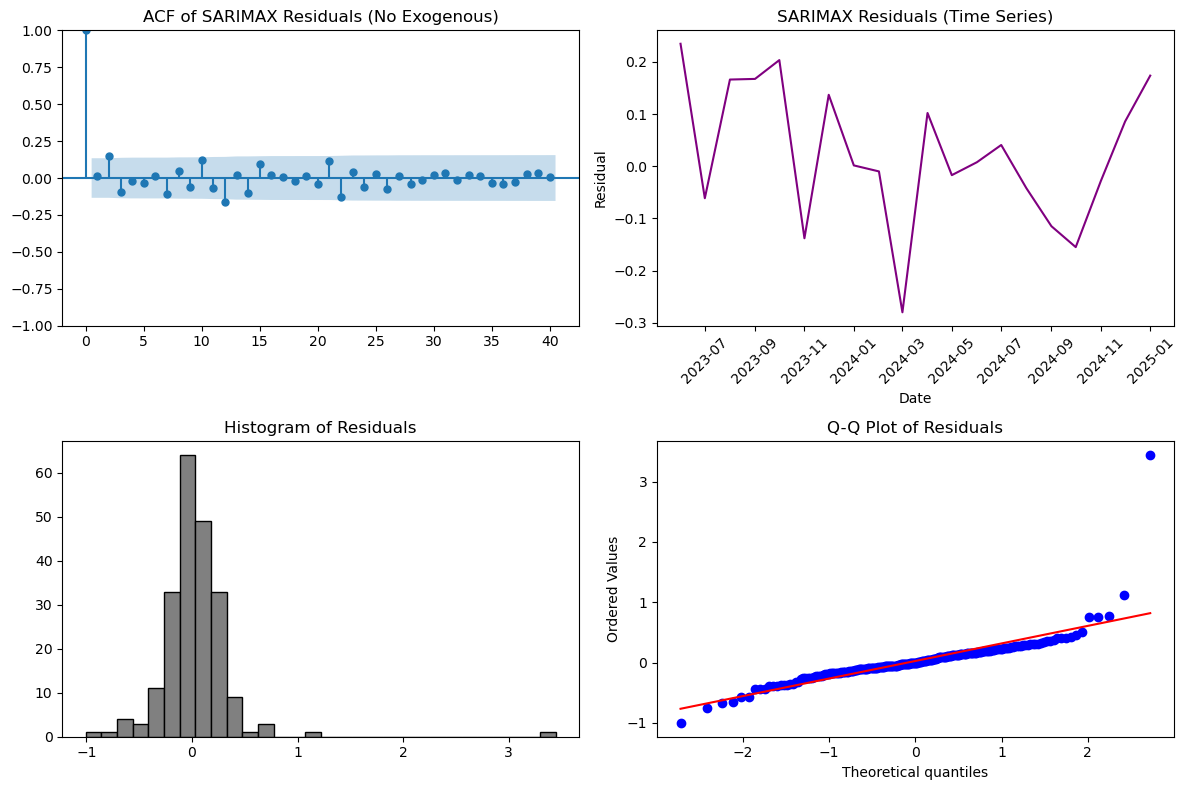

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  14.510000   0.150974
20  26.790299   0.141268
30  37.643805   0.159111


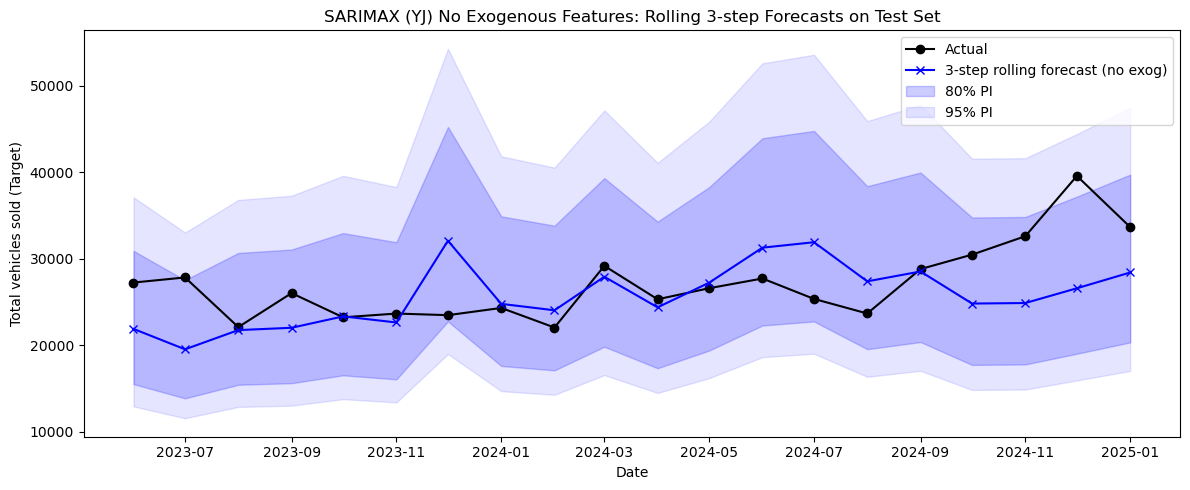

Test RMSE (rolling): 5263.42
Test MAPE (rolling): 13.77%


In [47]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# Settings
horizon = 3
lag = 6  # kept for compatibility but no exog features used now

# Combine train + val for fitting initial model
train_val_yj = np.concatenate([y_train_yj.values, y_val_yj.values])
test_yj = y_test_yj.values

n_train_val = len(train_val_yj)
n_test = len(test_yj)

lam = yeojohnson_lambdas_all[target_raw]

def inv_yeojohnson(z, lam):
    if np.isclose(lam, 0):
        return np.exp(z) - 1
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos] = np.power(z[pos] * lam + 1, 1 / lam) - 1
    out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1 / (2 - lam))
    return out

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

for t in range(n_test - horizon + 1):
    # Combine train+val + partial test history up to t
    y_hist = np.concatenate([train_val_yj, test_yj[:t]])

    # No exogenous variables now, so no exog preparation
    # Fit SARIMAX model without exog
    model = SARIMAX(
        y_hist,
        order=(0, 1, 1), # Let op heb 211 gedaan hier 
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fitted = model.fit(disp=False)

    # Forecast next horizon steps
    fc = fitted.get_forecast(steps=horizon)
    yj_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

actuals_level = inv_yeojohnson(test_yj[horizon - 1:], lam)
plot_dates = df["Time Period (T)"].iloc[val_end_yj + horizon - 1:test_end_yj][:len(preds_level)]

# Diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals (No Exogenous)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat', 'lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (no exog)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('SARIMAX (YJ) No Exogenous Features: Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Test RMSE (rolling): {rmse:.2f}")
print(f"Test MAPE (rolling): {mape:.2%}")


> Extra Lag test

In [ ]:
# import warnings
# import numpy as np
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.stats.diagnostic import acorr_ljungbox

# warnings.filterwarnings("ignore")

# # Settings
# horizon = 3
# lags_to_test = range(0, 13)  # lags 0 to 12 inclusive

# # Data
# train_yj = y_train_yj.values
# val_yj = y_val_yj.values

# features = {
#     'Gasoline': yj_df['Gasoline (Euro95) - Average price (F)_yj'].values,
#     'Company Car Tax': yj_df['Company car tax rate (%)_yj'].values,
#     'Home Charging': yj_df['Home charging (G)_yj'].values,
#     'Consumer Confidence': yj_df['Consumer confidence (E)_yj'].values
# }

# n_train = len(train_yj)
# n_val = len(val_yj)
# lam = yeojohnson_lambdas_all[target_raw]

# def make_lag(arr, lag):
#     out = np.roll(arr, lag)
#     out[:lag] = np.nan
#     return out

# def inv_yeojohnson(z, lam):
#     import numpy as np
#     if np.isclose(lam, 0):
#         return np.exp(z) - 1
#     elif lam == 2:
#         return -np.exp(-z)
#     out = np.zeros_like(z)
#     pos = z >= 0
#     out[pos] = np.power(z[pos] * lam + 1, 1 / lam) - 1
#     out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1 / (2 - lam))
#     return out

# for feat_name, feat_vals in features.items():
#     print(f"\n=== Testing feature: {feat_name} ===")
#     for lag in lags_to_test:
#         preds_level = []

#         for t in range(n_val - horizon + 1):
#             y_hist = np.concatenate([train_yj, val_yj[:t]])
#             idx_offset = n_train + t

#             feat_hist = np.concatenate([feat_vals[:n_train], feat_vals[n_train:n_train + t]])
#             feat_lag = make_lag(feat_hist, lag).reshape(-1, 1)

#             valid = ~np.isnan(feat_lag).flatten()
#             y_hist_valid = y_hist[valid]
#             feat_lag_valid = feat_lag[valid]

#             feat_future = feat_vals[:idx_offset + horizon]
#             feat_future_lag = make_lag(feat_future, lag)[-horizon:].reshape(-1, 1)

#             model = SARIMAX(
#                 y_hist_valid,
#                 exog=feat_lag_valid,
#                 order=(0, 1, 1),
#                 seasonal_order=(1, 0, 0, 12),
#                 enforce_stationarity=False,
#                 enforce_invertibility=False
#             )
#             fitted = model.fit(disp=False)

#             fc = fitted.get_forecast(steps=horizon, exog=feat_future_lag)
#             yj_forecast_level = fc.predicted_mean[-1]

#             preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

#         actuals_level = inv_yeojohnson(val_yj[horizon - 1:], lam)
#         rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
#         mape = mean_absolute_percentage_error(actuals_level, preds_level)

#         lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)

#         print(f"Lag {lag:2d} | RMSE: {rmse:10.2f} | MAPE: {mape:10.2%} | AIC: {fitted.aic:10.2f} | BIC: {fitted.bic:10.2f}")
#         print("Ljung-Box p-values (lags 10,20,30):", lb['lb_pvalue'].values)

# print("\nTesting complete.")


# # Collect best RMSE and corresponding lag for each feature
# best_results = []
# for feat_name, feat_vals in features.items():
#     min_rmse = float('inf')
#     best_lag = None
#     for lag in lags_to_test:
#         preds_level = []
#         for t in range(n_val - horizon + 1):
#             y_hist = np.concatenate([train_yj, val_yj[:t]])
#             idx_offset = n_train + t
#             feat_hist = np.concatenate([feat_vals[:n_train], feat_vals[n_train:n_train + t]])
#             feat_lag = make_lag(feat_hist, lag).reshape(-1, 1)
#             valid = ~np.isnan(feat_lag).flatten()
#             y_hist_valid = y_hist[valid]
#             feat_lag_valid = feat_lag[valid]
#             feat_future = feat_vals[:idx_offset + horizon]
#             feat_future_lag = make_lag(feat_future, lag)[-horizon:].reshape(-1, 1)
#             model = SARIMAX(
#                 y_hist_valid,
#                 exog=feat_lag_valid,
#                 order=(1, 1, 1),
#                 seasonal_order=(1, 0, 0, 12),
#                 enforce_stationarity=False,
#                 enforce_invertibility=False
#             )
#             fitted = model.fit(disp=False)
#             fc = fitted.get_forecast(steps=horizon, exog=feat_future_lag)
#             yj_forecast_level = fc.predicted_mean[-1]
#             preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])
#         actuals_level = inv_yeojohnson(val_yj[horizon - 1:], lam)
#         rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
#         if rmse < min_rmse:
#             min_rmse = rmse
#             best_lag = lag
#     best_results.append((feat_name, min_rmse, best_lag))

# # Sort and print summary
# best_results.sort(key=lambda x: x[1])
# print("\n=== Best RMSE by Feature (sorted) ===")
# for feat_name, min_rmse, best_lag in best_results:
#     print(f"{feat_name:25s} | Best RMSE: {min_rmse:10.2f} | Lag: {best_lag}")


In [ ]:
# ### Same thing but on test 

# import warnings
# import numpy as np
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.stats.diagnostic import acorr_ljungbox

# warnings.filterwarnings("ignore")

# # Settings
# horizon = 3
# lags_to_test = range(0, 13)  # lags 0 to 12 inclusive

# # Data
# train_yj = y_train_yj.values
# val_yj = y_val_yj.values
# test_yj = y_test_yj.values

# features = {
#     'Gasoline': yj_df['Gasoline (Euro95) - Average price (F)_yj'].values,
#     'Company Car Tax': yj_df['Company car tax rate (%)_yj'].values,
#     'Home Charging': yj_df['Home charging (G)_yj'].values,
#     'Consumer Confidence': yj_df['Consumer confidence (E)_yj'].values
# }

# n_train = len(train_yj)
# n_val = len(val_yj)
# n_test = len(test_yj)
# lam = yeojohnson_lambdas_all[target_raw]

# def make_lag(arr, lag):
#     out = np.roll(arr, lag)
#     out[:lag] = np.nan
#     return out

# def inv_yeojohnson(z, lam):
#     import numpy as np
#     if np.isclose(lam, 0):
#         return np.exp(z) - 1
#     elif lam == 2:
#         return -np.exp(-z)
#     out = np.zeros_like(z)
#     pos = z >= 0
#     out[pos] = np.power(z[pos] * lam + 1, 1 / lam) - 1
#     out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1 / (2 - lam))
#     return out

# print("Starting tests on test set using train + val for training...\n")

# for feat_name, feat_vals in features.items():
#     print(f"=== Feature: {feat_name} ===")
#     for lag in lags_to_test:
#         preds_level = []

#         # Combine train + val for history
#         train_val_yj = np.concatenate([train_yj, val_yj])
#         n_train_val = len(train_val_yj)

#         for t in range(n_test - horizon + 1):
#             # History includes train+val + partial test history up to t
#             y_hist = np.concatenate([train_val_yj, test_yj[:t]])

#             feat_hist = np.concatenate([feat_vals[:n_train_val], feat_vals[n_train_val:n_train_val + t]])
#             feat_lag = make_lag(feat_hist, lag).reshape(-1, 1)

#             valid = ~np.isnan(feat_lag).flatten()
#             y_hist_valid = y_hist[valid]
#             feat_lag_valid = feat_lag[valid]

#             feat_future = feat_vals[:n_train_val + t + horizon]
#             feat_future_lag = make_lag(feat_future, lag)[-horizon:].reshape(-1, 1)

#             model = SARIMAX(
#                 y_hist_valid,
#                 exog=feat_lag_valid,
#                 order=(1, 1, 1),
#                 seasonal_order=(1, 0, 0, 12),
#                 enforce_stationarity=False,
#                 enforce_invertibility=False
#             )
#             fitted = model.fit(disp=False)

#             fc = fitted.get_forecast(steps=horizon, exog=feat_future_lag)
#             yj_forecast_level = fc.predicted_mean[-1]

#             preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

#         actuals_level = inv_yeojohnson(test_yj[horizon - 1:], lam)
#         rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
#         mape = mean_absolute_percentage_error(actuals_level, preds_level)

#         lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)

#         print(f"Lag {lag:2d} | RMSE: {rmse:10.2f} | MAPE: {mape:10.2%} | AIC: {fitted.aic:10.2f} | BIC: {fitted.bic:10.2f}")
#         print("Ljung-Box p-values (lags 10,20,30):", lb['lb_pvalue'].values)
#     print("\n")

# print("Testing complete.")
